In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import mannwhitneyu

from madrigal.utils import BASE_DIR

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
%matplotlib inline

DDI_PATH = BASE_DIR+'processed_data/polypharmacy_new/DrugBank/'
VIEWS_PATH = BASE_DIR+'processed_data/views_features_new/'

['str', 'kg', 'cv']


# Utils

In [ ]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.startswith("view_tx_") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

# FDA approved drugs from Drugbank site
organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')
organ_class_mapping = organs_csv.set_index("ddi_class").to_dict()["organ"]  # ddi_class : organ

# needed for drug mapping
drugbank_vocab = pd.read_csv("../drugbank_vocabulary.csv")[["DrugBank ID", "Common name", "Synonyms"]]
drugbank_vocab["Synonyms"] = drugbank_vocab["Synonyms"].apply(lambda lst: [syn.lower().replace("-", "").replace(" ", "") for syn in lst.split(" | ")] if lst == lst else [])
drugbank_vocab["Common name new"] = drugbank_vocab["Common name"].str.lower().str.replace("-", "").str.replace(" ", "")
drugbank_vocab["all_names"] = drugbank_vocab[["Common name new", "Synonyms"]].apply(
    lambda row: [row[0]] + row[1],
    axis=1
)
drugbank_vocab = drugbank_vocab[["DrugBank ID", "all_names", "Common name"]]

drug_id_to_ind = drug_metadata[["node_id"]].dropna().reset_index().set_index("node_id").to_dict()["index"]
ddi_classes = pd.read_pickle(DDI_PATH + "drugbank_ddi_directed_final_label_map.pkl")
assert np.all(ddi_classes.values == np.array(list(organ_class_mapping.keys())))

to_delete = [
    10, 
    23, 
    24, 
    38, 
    47, 
    49, 
    50, 
    65, 
    72,
    83,
    99, 
    136,
    138,
    139,
    140,
    141,
    147
]
to_delete_classes = [
    "adverse effects, decrease", 
    "bioavailability, decrease", 
    "bioavailability, increase", 
    "cardiotoxicity, decrease",
    "excretion rate, decrease | serum level, increase", 
    "excretion, decrease",
    "excretion, increase",
    "hypertension, decrease",
    "hypoglycemia, decrease",
    "hypotension, decrease",
    "nephrotoxicity, decrease",
    "serum level of the active metabolites, decrease",
    "serum level of the active metabolites, increase",
    "serum level, decrease",
    "serum level, increase",
    "stimulatory, decrease",
    "therapeutic efficacy, increase",
]


Index(['drugbank_id', 'drug_name', 'drug_type', 'smiles', 'inchikey',
       'description', 'indication', 'pharmacodynamics', 'moa', 'absorption',
       'metabolism', 'toxicity', 'atc_codes', 'classifications', 'targets',
       'enzymes', 'carriers', 'transporters'],
      dtype='object')


In [ ]:
# # NOTE: The commented code below generates `normalized_ranks_drugbank_self_combos_gmean_aggregated.npy`

data_source = "DrugBank"
split_method = "split_by_pairs"
repeat = None
epoch = 700
kg_encoder = "hgt"
eval_type = "full_full"

# checkpoints = [
#     "drawn-grass-4",  # DrugBank (trained on all data, seed=1)
#     "misty-oath-5",  # DrugBank (trained on all data, seed=0)
#     "whole-fog-7",  # DrugBank (trained on all data, seed=99)
#     "snowy-serenity-8",  # DrugBank (trained on all data, seed=42)
#     "revived-aardvark-8",  # DrugBank (trained on all data, seed=2)
# ]

# raw_score_drugbank_self_combos_list = []
# for checkpoint in checkpoints:
#     eval_type = "full_full"
#     checkpoint_dir = BASE_PATH + f"model_output/{data_source}/{split_method}/{checkpoint}/"
#     raw_scores_drugbank = np.load(
#         checkpoint_dir + f"{eval_type}_all_ddi_{data_source}_drugs_raw_scores_{epoch}.npy", 
#         mmap_mode = "r+"
#     )
#     raw_scores_drugbank_self_combos = np.asarray(raw_scores_drugbank[:, np.arange(raw_scores_drugbank.shape[1]), np.arange(raw_scores_drugbank.shape[2])])
#     raw_score_drugbank_self_combos_list.append(raw_scores_drugbank_self_combos)

# normalized_ranks_drugbank_self_combos_gmean_aggregated = gmean(
#     rankdata(np.stack(raw_score_drugbank_self_combos_list), axis=-1) / raw_score_drugbank_self_combos_list[0].shape[-1],
#     axis=0
# )
# np.save(BASE_PATH + f"model_output/{data_source}/{split_method}/normalized_ranks_drugbank_self_combos_gmean_aggregated.npy", normalized_ranks_drugbank_self_combos_gmean_aggregated)

normalized_ranks_drugbank_self_combos_gmean_aggregated = np.load(BASE_DIR + f"model_output/{data_source}/{split_method}/normalized_ranks_drugbank_self_combos_gmean_aggregated.npy")

# Single-drug adverse events

## Drug Induced Liver Injury Rank (DILIrank) Dataset

[FDA DILIrank](https://www.fda.gov/science-research/liver-toxicity-knowledge-base-ltkb/drug-induced-liver-injury-rank-dilirank-dataset)

In [ ]:
dili_data = pd.read_excel(BASE_DIR + "raw_data/DILIrank/DILIrank-DILIscore_List.xlsx", sheet_name=0, skiprows=1)
dili_data = dili_data[["Compound Name", "Severity Class", "Label Section", "vDILIConcern", "Version"]]
assert dili_data.shape[0] == dili_data.drop_duplicates(subset=["Compound Name"]).shape[0]
print(dili_data.shape[0])

1036


In [23]:
temp = dili_data["Compound Name"].str.lower().str.replace("-", "").str.replace(" ", "").apply(lambda x: drugbank_vocab["all_names"].apply(lambda lst: (x in lst)))
dili_data["drugbank_id_mapped"] = temp.apply(lambda row: drugbank_vocab["DrugBank ID"].values[row], axis=1)

display(dili_data[dili_data["drugbank_id_mapped"].apply(len) > 1])
dili_data.loc[984, "drugbank_id_mapped"] = ["DB00125"]

dili_data["drugbank_id_mapped"] = dili_data["drugbank_id_mapped"].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)
dili_data = dili_data.dropna(subset=["drugbank_id_mapped"])
dili_data = dili_data.query("drugbank_id_mapped in @drug_metadata.node_id.values")

display(dili_data[dili_data.duplicated(subset=["drugbank_id_mapped"], keep=False)])
dili_data["drug_ind"] = dili_data["drugbank_id_mapped"].apply(lambda x: drug_id_to_ind[x])

,Compound Name,Severity Class,Label Section,vDILIConcern,Version,drugbank_id_mapped
984,l-arginine,0,No match,vNo-DILI-Concern,2,"[DB00125, DB17289]"


,Compound Name,Severity Class,Label Section,vDILIConcern,Version,drugbank_id_mapped


In [24]:
dili_data["vDILIConcern"].value_counts()

vDILIConcern
vLess-DILI-Concern        262
vNo-DILI-Concern          234
Ambiguous DILI-concern    217
vMost-DILI-Concern        159
Name: count, dtype: int64

In [26]:
liver_ddi_class_indices = [i for i, (_, organ) in enumerate(organ_class_mapping.items()) if "liver" in organ]
liver_ddi_class_indices_filtered = list(set(liver_ddi_class_indices) - set(to_delete))
print(liver_ddi_class_indices_filtered)
print([ddi_classes[i] for i in liver_ddi_class_indices_filtered])

[48, 89, 90, 91, 92]
['excretion rate, increase | serum level, decrease | efficacy, decrease', 'liver damage, increase', 'liver enzyme elevations, increase', 'metabolism, decrease', 'metabolism, increase']


In [ ]:
# get normalized ranks of each drug self-combo for each filtered liver class
class_normalized_rank_drugbank_self_combos = {}
for ddi_class_ind in liver_ddi_class_indices_filtered:
    class_normalized_rank_drugbank_self_combos[ddi_class_ind] = normalized_ranks_drugbank_self_combos_gmean_aggregated[ddi_class_ind]
    dili_data[f"ddi_class_{ddi_class_ind}_norm_rank"] = class_normalized_rank_drugbank_self_combos[ddi_class_ind][dili_data["drug_ind"].values]

dili_data["DILI_concern_level"] = dili_data["vDILIConcern"].replace({
    "vMost-DILI-Concern":"Most", "vLess-DILI-Concern":"Less", "Ambiguous DILI-concern":"Ambiguous", "vNo-DILI-Concern":"No"
})

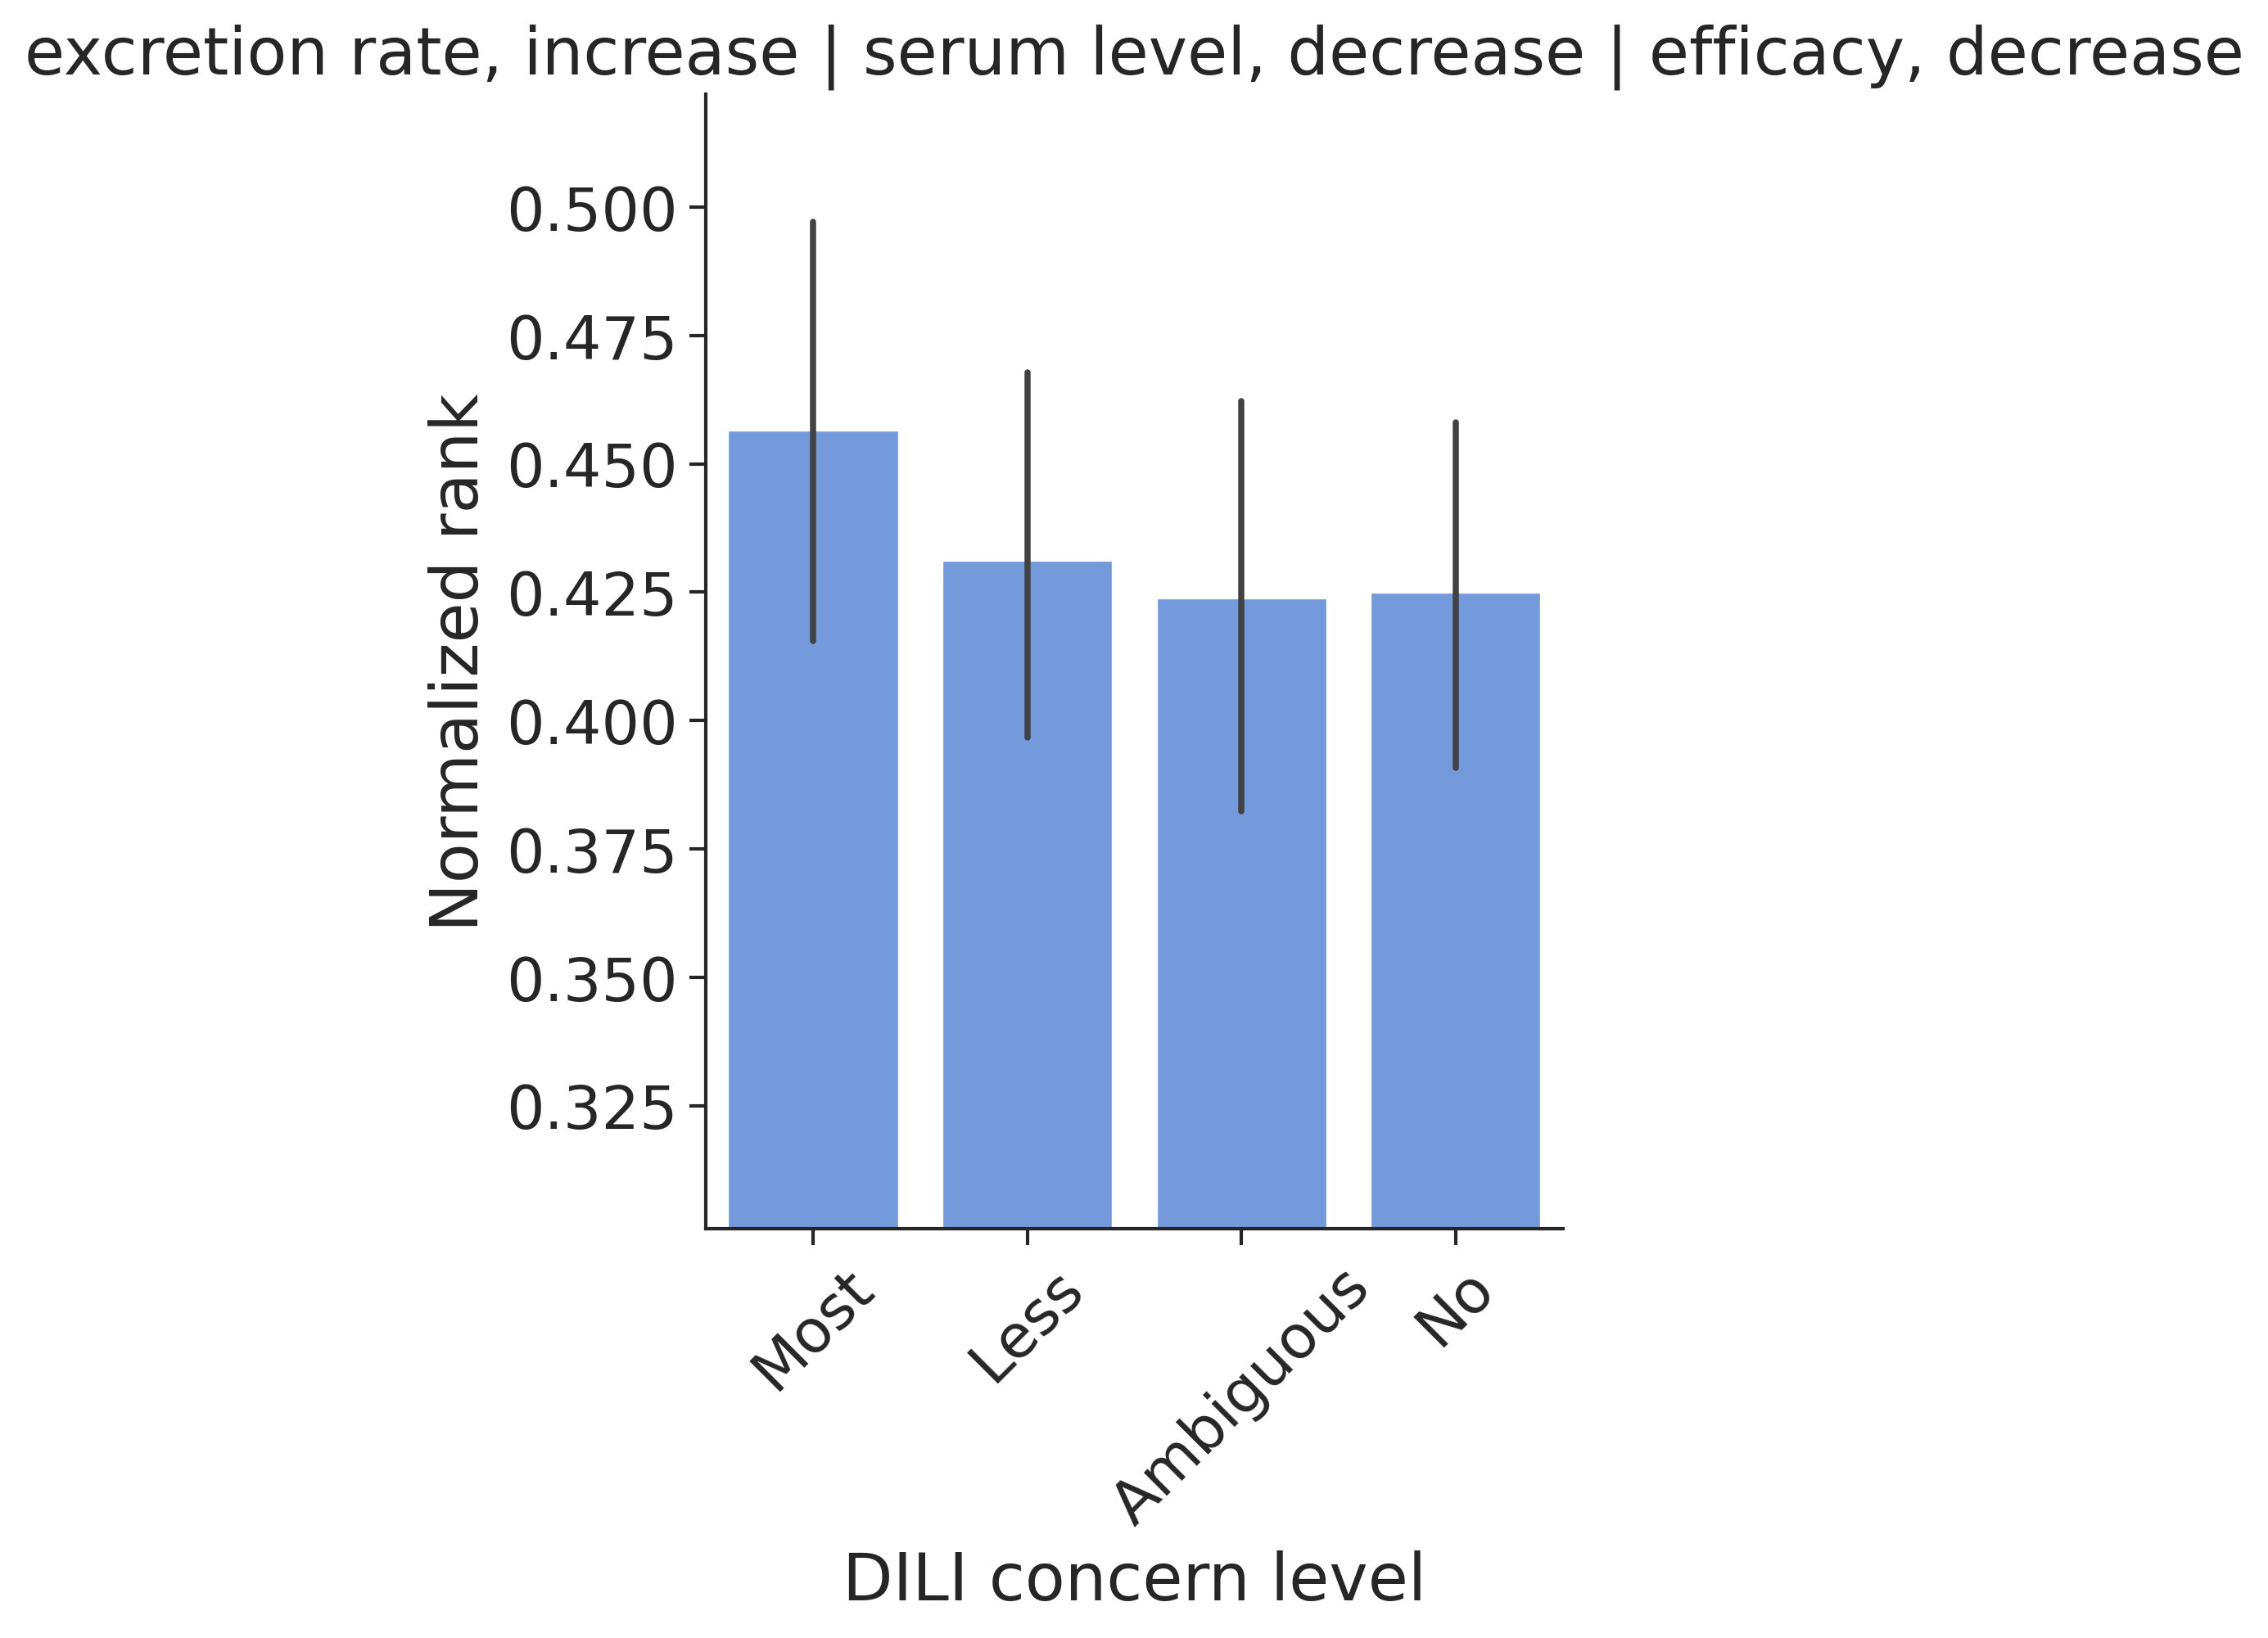

MannwhitneyuResult(statistic=22127.0, pvalue=0.2837225035265166)
MannwhitneyuResult(statistic=28907.0, pvalue=0.7505121605586158)
MannwhitneyuResult(statistic=24872.0, pvalue=0.708799812060273)
MannwhitneyuResult(statistic=30771.0, pvalue=0.9417181827978099)


In [31]:
ddi_class_ind = 48
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)
sns.barplot(data=dili_data, x="DILI_concern_level", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DILI concern level")
plt.ylabel("Normalized rank")
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_dili_48.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))


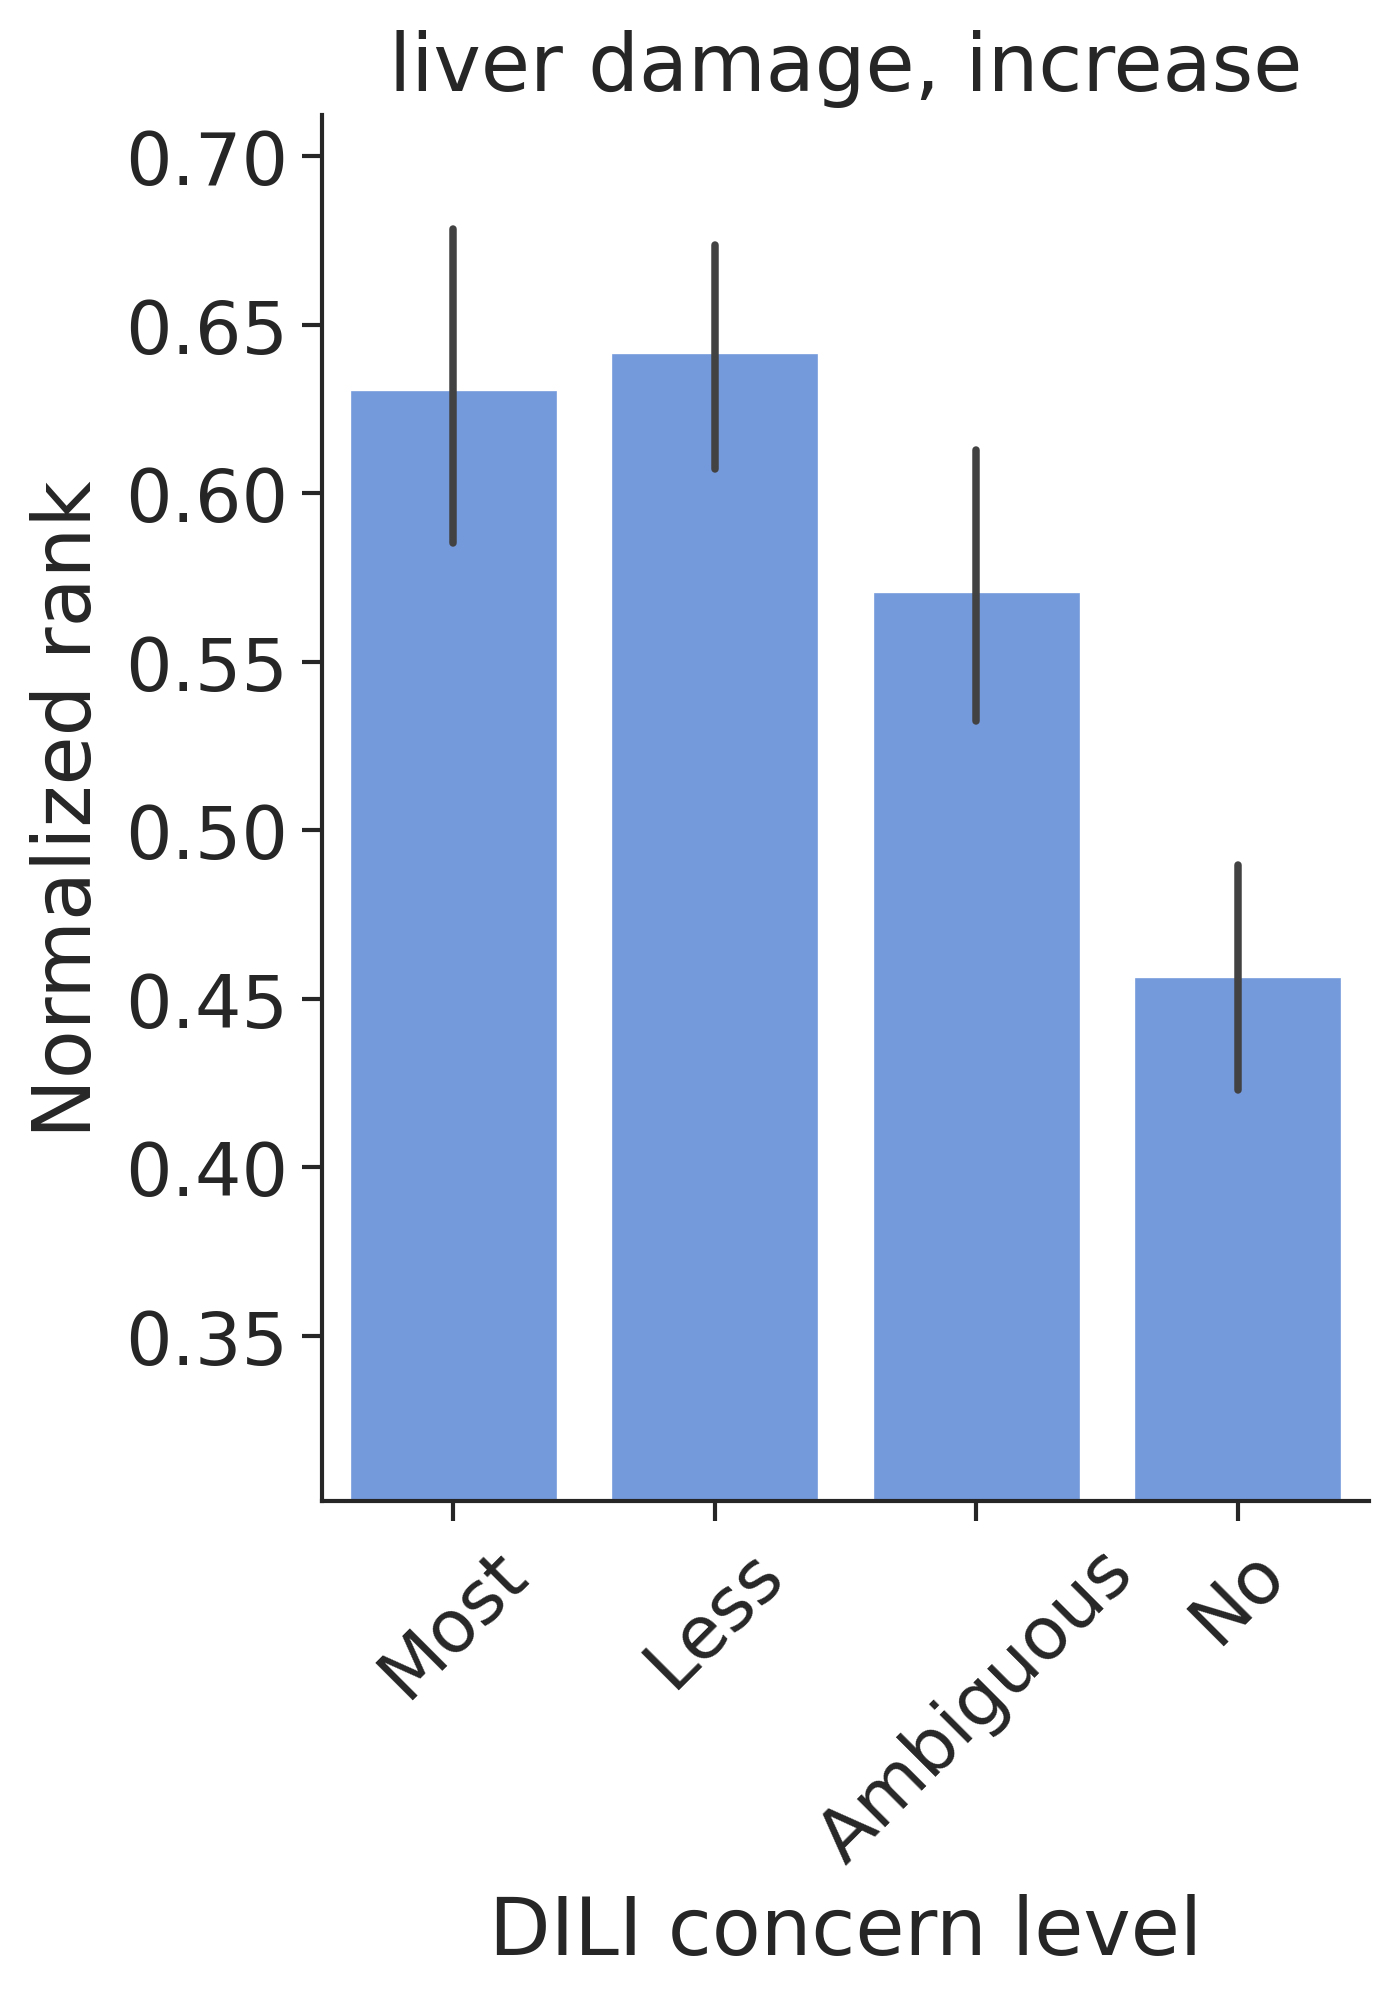

MannwhitneyuResult(statistic=20805.0, pvalue=0.9845094860133082)
MannwhitneyuResult(statistic=32288.0, pvalue=0.01046844439412704)
MannwhitneyuResult(statistic=31101.0, pvalue=3.6300730327283704e-05)
MannwhitneyuResult(statistic=19458.0, pvalue=0.0341044596258798)


In [32]:
ddi_class_ind = 89
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=dili_data, x="DILI_concern_level", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DILI concern level")
plt.ylabel("Normalized rank")
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_dili_liver_damage.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

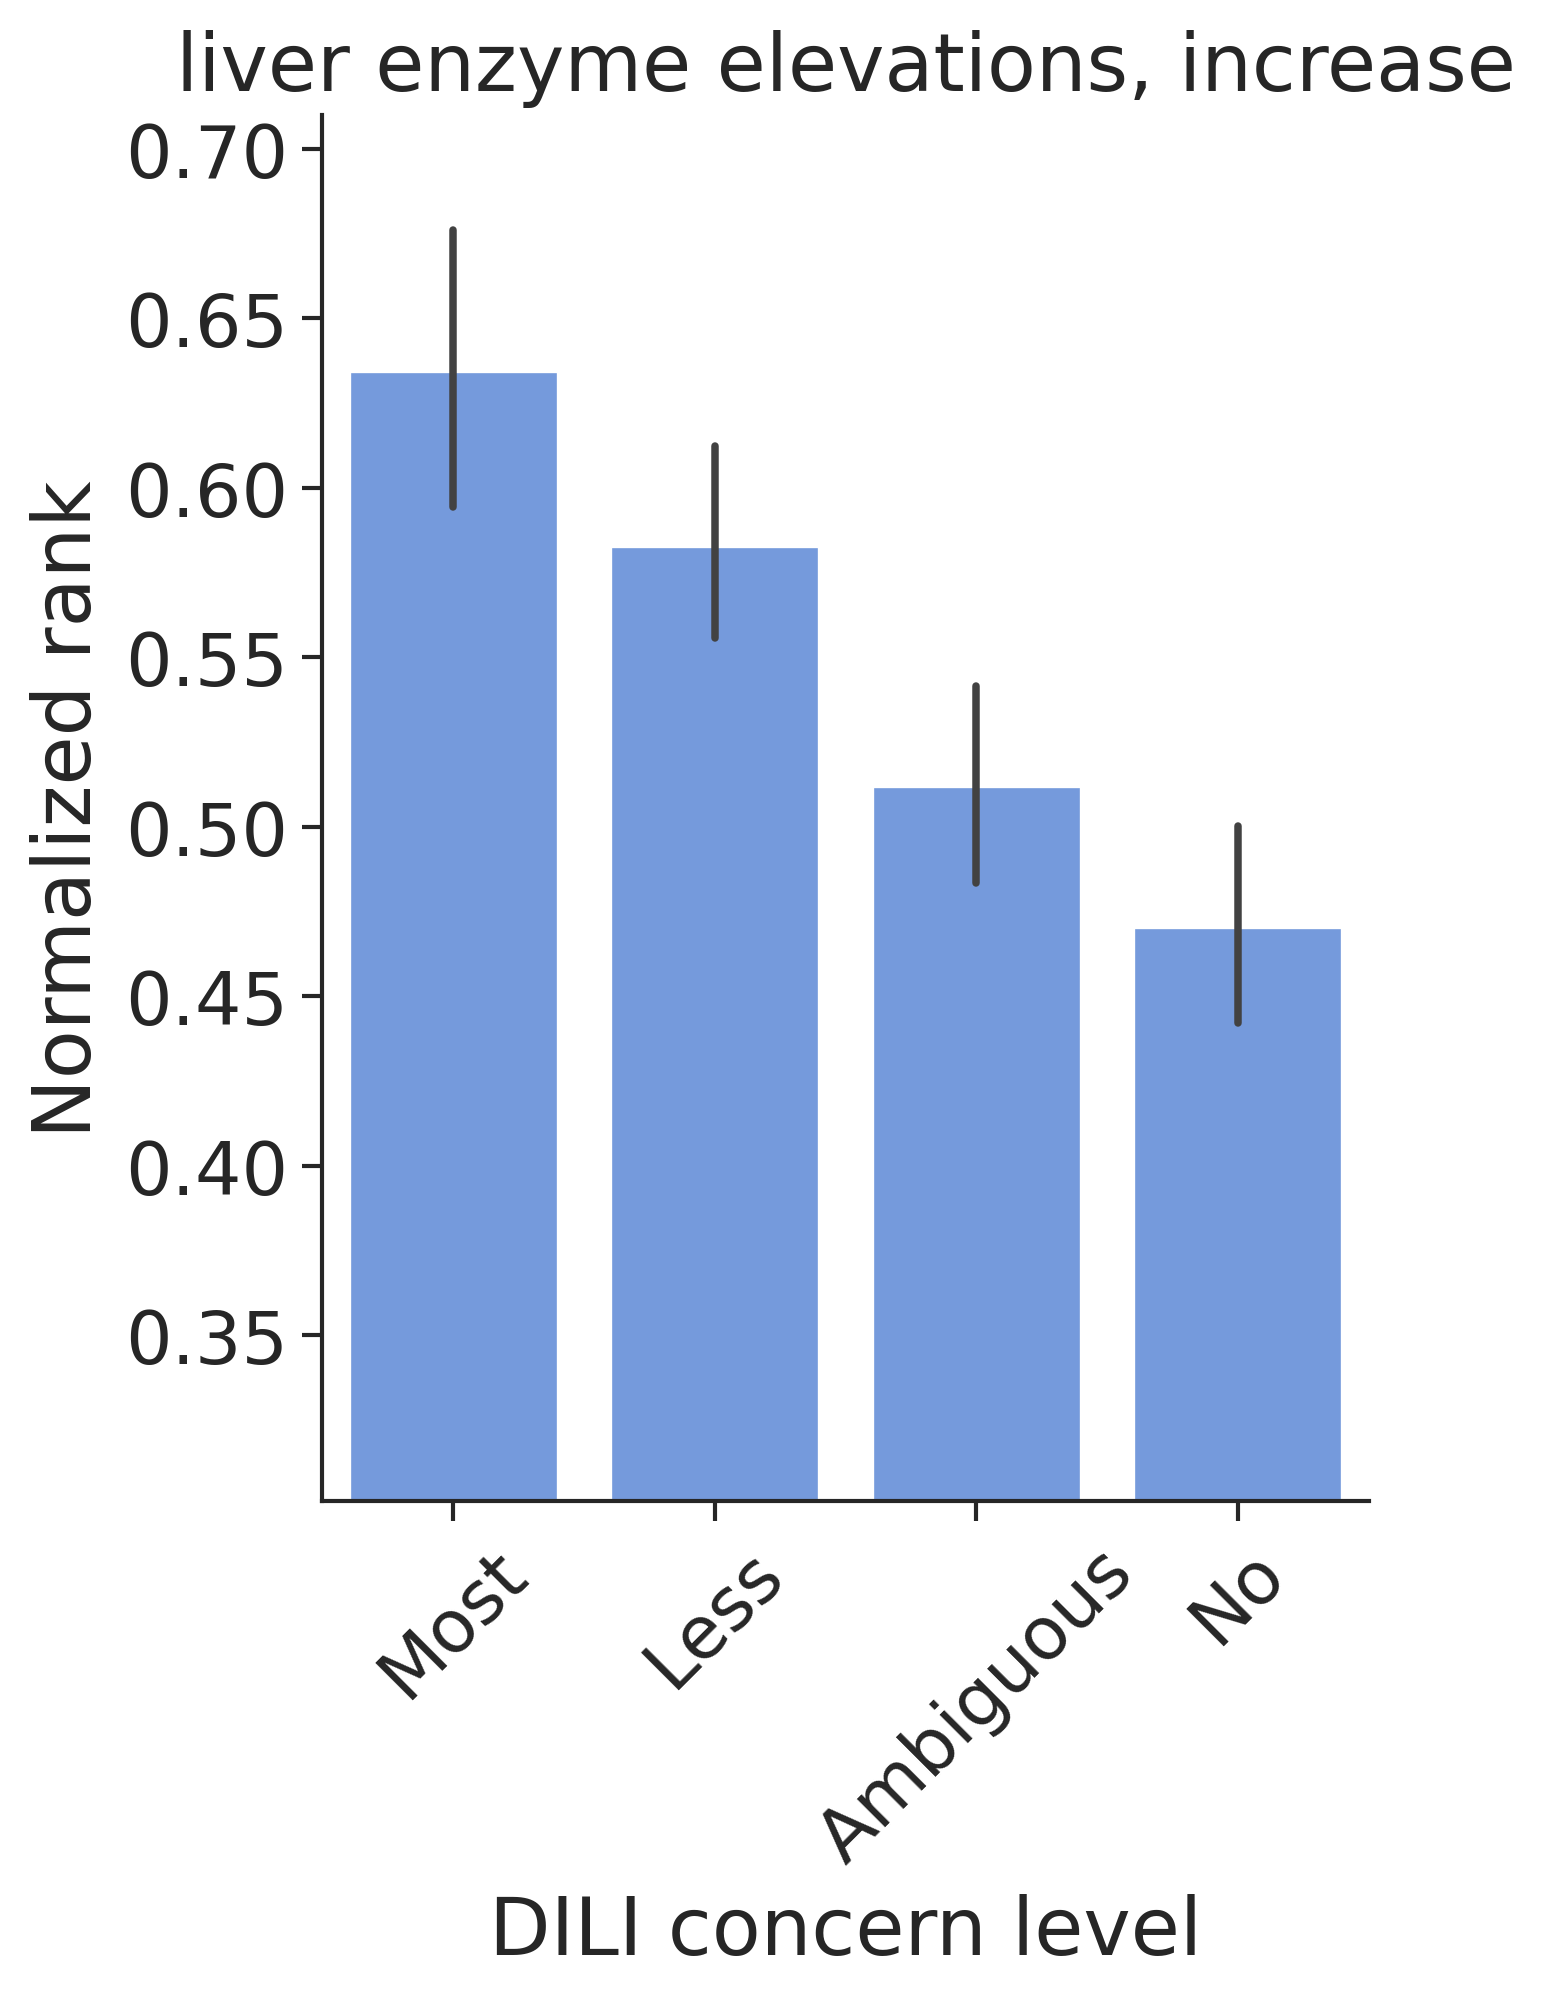

MannwhitneyuResult(statistic=23931.0, pvalue=0.010393377018318049)
MannwhitneyuResult(statistic=33426.0, pvalue=0.0009177920227311325)
MannwhitneyuResult(statistic=27407.0, pvalue=0.14461886908693541)
MannwhitneyuResult(statistic=38551.0, pvalue=7.214023132461446e-07)


In [33]:
ddi_class_ind = 90
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=dili_data, x="DILI_concern_level", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DILI concern level")
plt.ylabel("Normalized rank")
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_dili_liver_enzyme_elevation.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

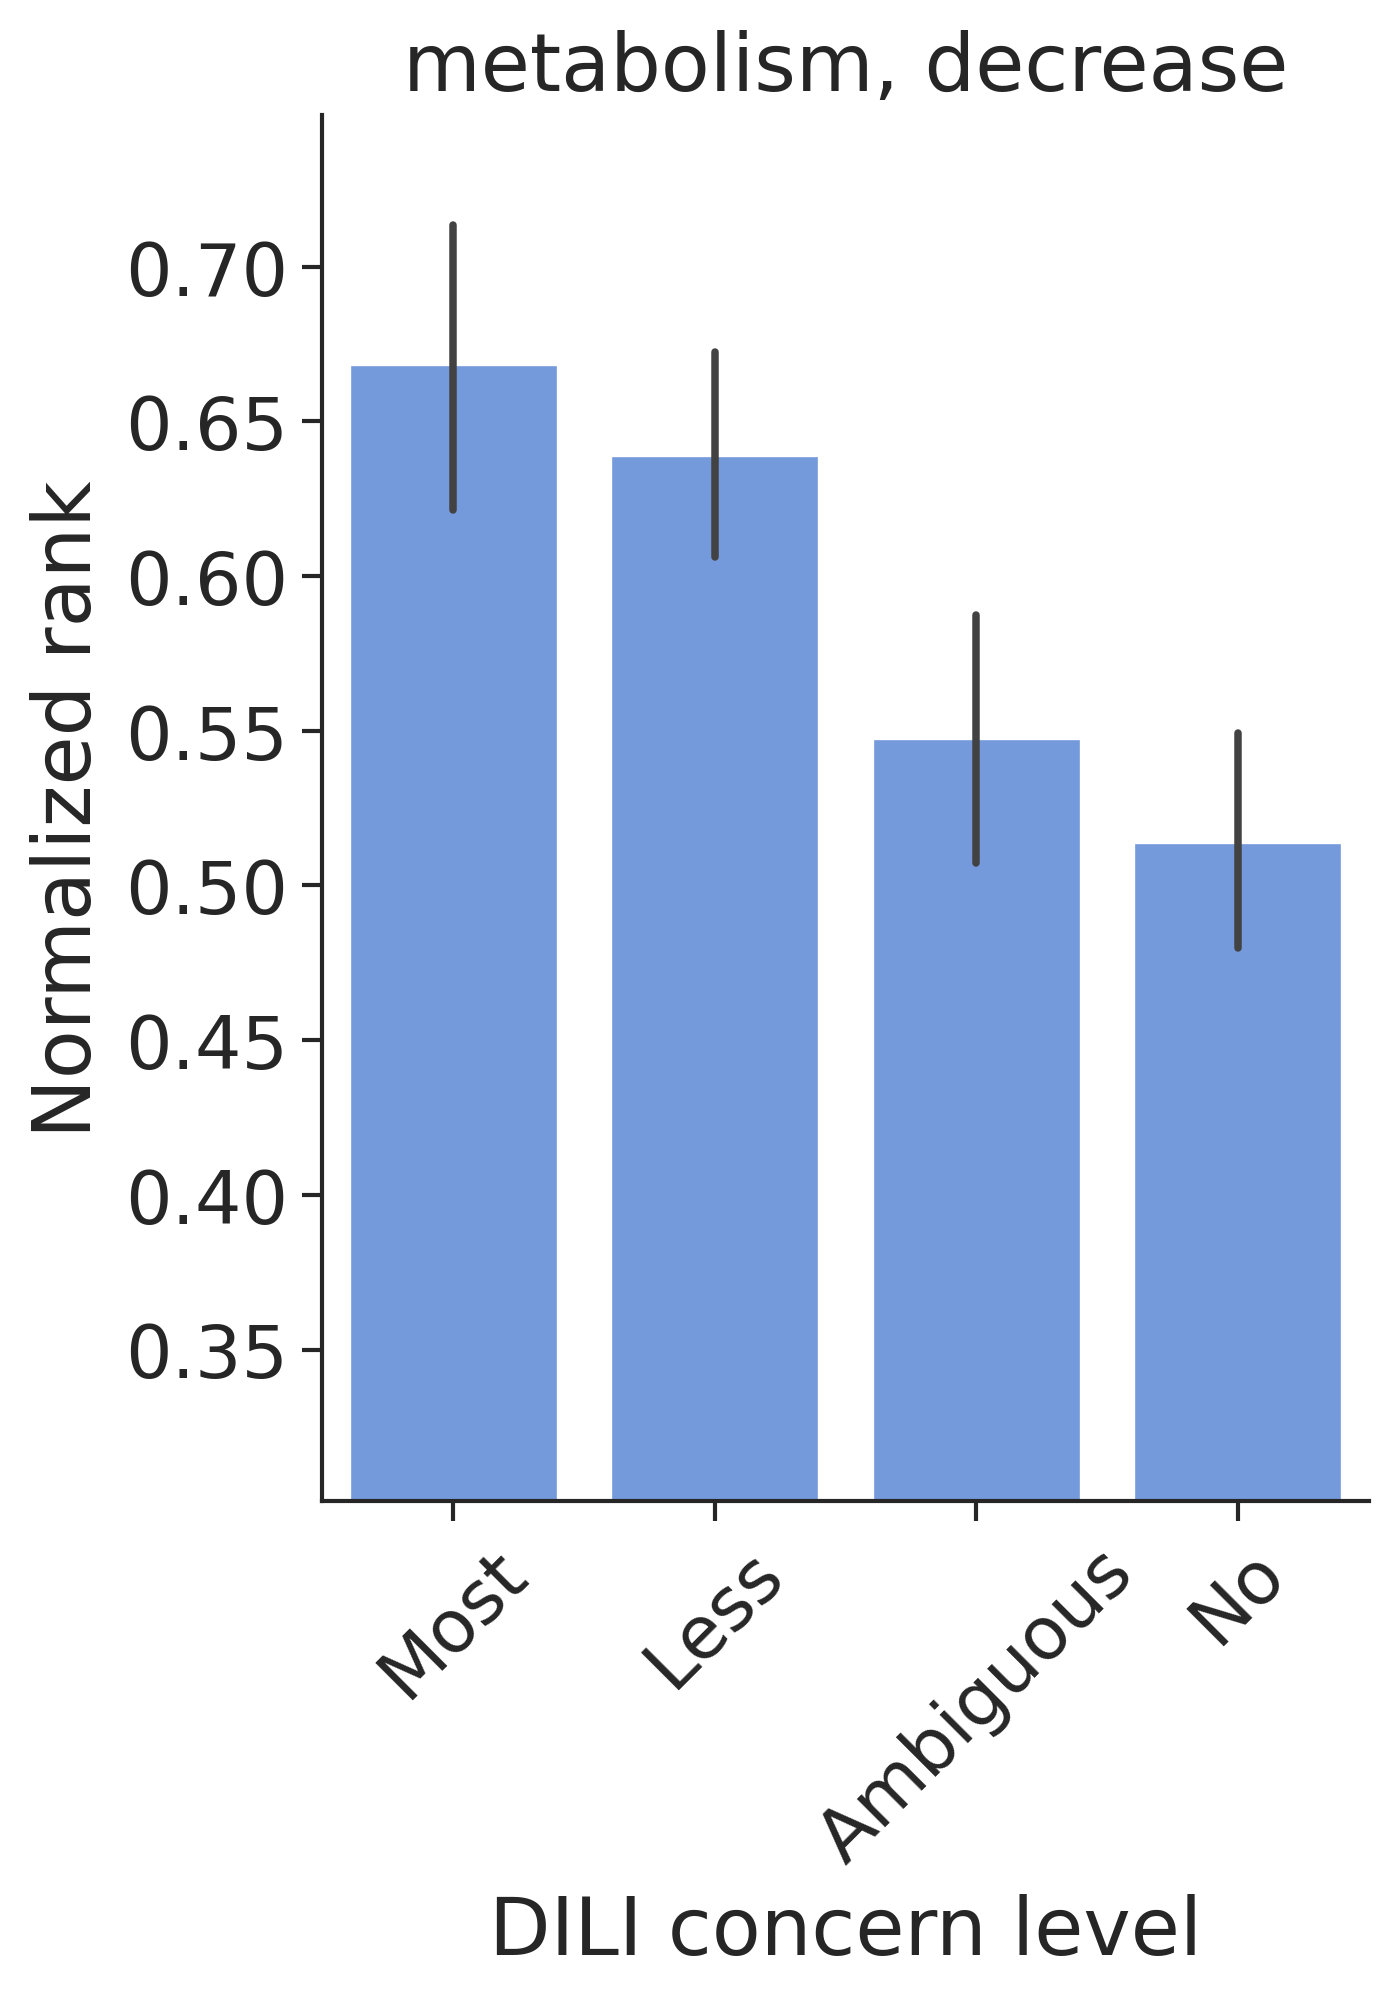

MannwhitneyuResult(statistic=22829.0, pvalue=0.09853722209669402)
MannwhitneyuResult(statistic=33484.0, pvalue=0.0007992743974623719)
MannwhitneyuResult(statistic=27074.0, pvalue=0.22321615327757782)
MannwhitneyuResult(statistic=38494.0, pvalue=8.66589130172499e-07)


In [35]:
ddi_class_ind = 91
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=dili_data, x="DILI_concern_level", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DILI concern level")
plt.ylabel("Normalized rank")
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_dili_91.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

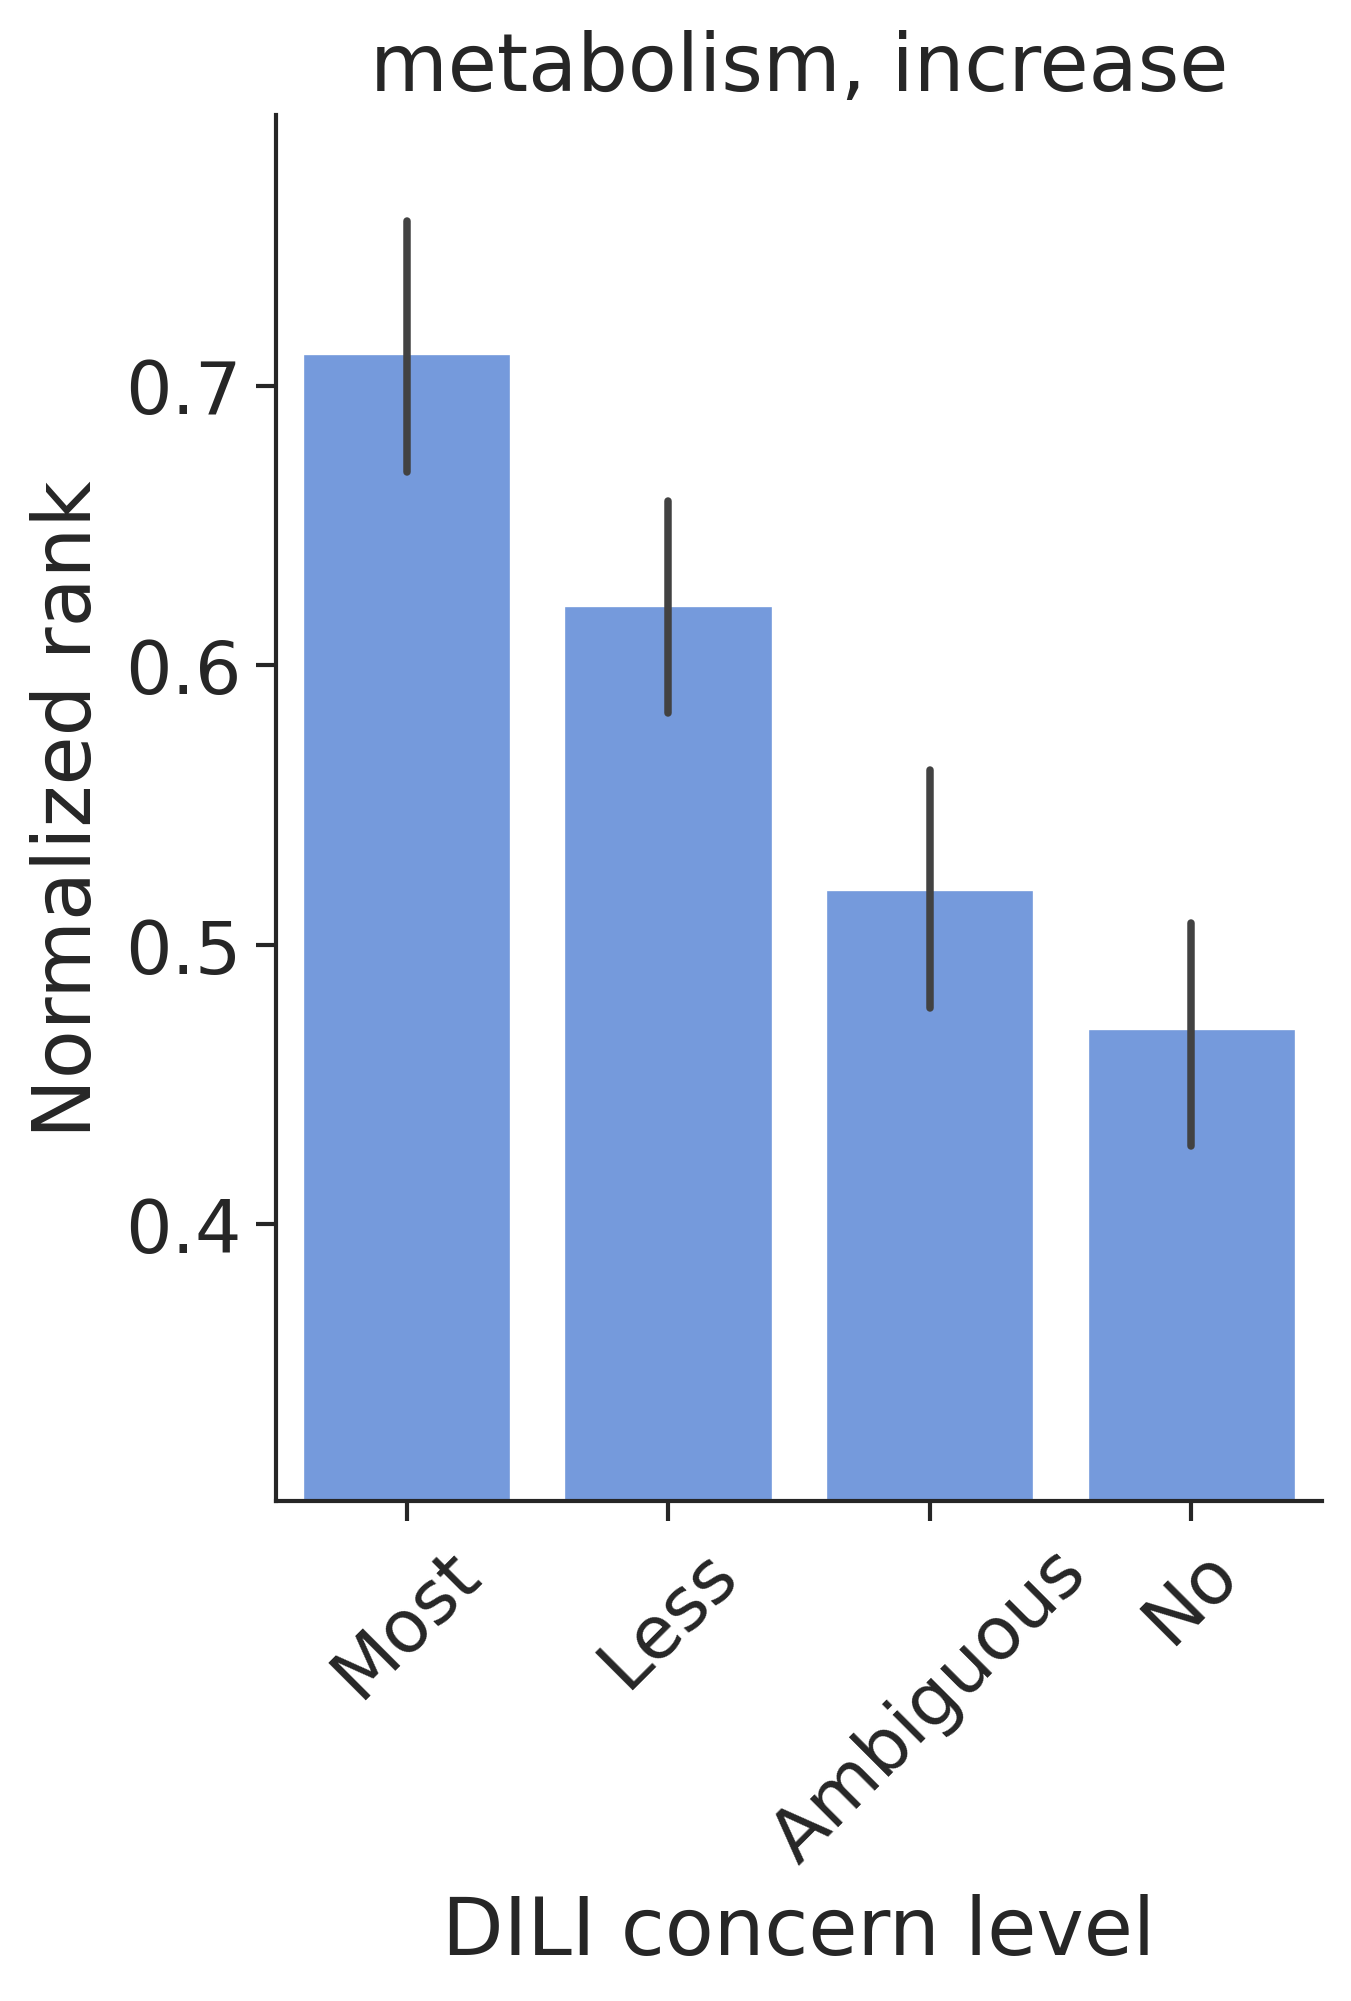

MannwhitneyuResult(statistic=24482.0, pvalue=0.002547046976293169)
MannwhitneyuResult(statistic=33718.0, pvalue=0.00045112417894145764)
MannwhitneyuResult(statistic=27433.0, pvalue=0.1395136263825934)
MannwhitneyuResult(statistic=38641.0, pvalue=5.386950501445686e-07)


In [36]:
ddi_class_ind = 92
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=dili_data, x="DILI_concern_level", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DILI concern level")
plt.ylabel("Normalized rank")
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_dili_92.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Most'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    dili_data.query("DILI_concern_level == 'Less'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    dili_data.query("DILI_concern_level == 'No'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

## Drug Induced Cardiotoxicity (DICTrank)

Original [DICTrank paper](https://www.sciencedirect.com/science/article/pii/S1359644623002866)

In [ ]:
dict_data = pd.read_excel(BASE_DIR + "raw_data/DICTrank/1-s2.0-S1359644623002866-mmc1.xlsx", sheet_name=0)
dict_data["Trade Name"] = dict_data["Trade Name"].str.lower()
dict_data["Generic/Proper Name(s)"] = dict_data["Generic/Proper Name(s)"].str.lower()
dict_data["Active Ingredient(s)"] = dict_data["Active Ingredient(s)"].str.lower()
dict_data["DICT _ Concern"] = dict_data["DICT _ Concern"].str.replace(" ", "").str.lower()
dict_data["DIC Severity Level"] = dict_data["DIC Severity Level"].str.lower()
# display(dict_data[dict_data["Generic/Proper Name(s)"].duplicated(keep=False)].sort_values("Generic/Proper Name(s)"))

print(dict_data["DICT _ Concern"].value_counts())
print(dict_data["DIC Severity Level"].value_counts())

DICT _ Concern
less         527
no           343
most         341
ambiguous    107
Name: count, dtype: int64
DIC Severity Level
mild        410
severe      366
moderate    113
Name: count, dtype: int64


In [ ]:
dict_data_agg = dict_data.groupby("Generic/Proper Name(s)").agg(list).reset_index()
dict_data_agg["all_names"] = dict_data_agg[["Trade Name", "Generic/Proper Name(s)", "Active Ingredient(s)"]].apply(
    lambda row: 
    list(set([name.lower().replace("-", "").replace(" ", "") for name in row[0] + [row[1]] + row[2] if name == name])), 
    axis=1
)
dict_data_agg = dict_data_agg.drop(columns=["Trade Name", "Active Ingredient(s)", "Label Section "])

dict_data_agg["Cardiotoxicity"] = dict_data_agg["Cardiotoxicity"].apply(
    lambda lst: list(ddi_type.lower() for ddi_type in set(lst) if ddi_type == ddi_type)
)
dict_data_agg["DICT _ Concern"] = dict_data_agg["DICT _ Concern"].apply(
    lambda lst: "most" if "most" in lst else ("less" if "less" in lst else ("ambiguous" if "ambiguous" in lst else "no"))
)
dict_data_agg["Keywords"] = dict_data_agg["Keywords"].apply(
    lambda lst: list(kw.lower() for kw in set(lst) if kw == kw)
)
dict_data_agg["DIC Severity Level"] = dict_data_agg["DIC Severity Level"].apply(
    lambda lst: "severe" if "severe" in lst else ("moderate" if "moderate" in lst else "mild")
)

temp = dict_data_agg["all_names"].apply(lambda dict_drug_name_lst: drugbank_vocab["all_names"].apply(lambda drugbank_drug_name_list: set(dict_drug_name_lst) & set(drugbank_drug_name_list) != set()))
dict_data_agg["drugbank_id_mapped"] = temp.apply(lambda row: drugbank_vocab["DrugBank ID"].values[row], axis=1)
dict_data_agg["drugbank_name_mapped"] = temp.apply(lambda row: drugbank_vocab["Common name"].values[row], axis=1)

In [43]:
unmapped = dict_data_agg[dict_data_agg["drugbank_id_mapped"].apply(len) < 1]
temp = unmapped["all_names"].apply(
    lambda dict_drug_name_lst: 
    drug_metadata["cmap_name"].dropna().apply(
        lambda cmap_drug_name_list: 
        set(dict_drug_name_lst) & \
        set([drug.lower().replace("-", "").replace(" ", "") for drug in cmap_drug_name_list]) != set()
    )
)
unmapped["drugbank_id_mapped"] = temp.apply(lambda row: drug_metadata.dropna(subset=["cmap_name"])["node_id"].values[row], axis=1)
unmapped["drug_ind"] = temp.apply(lambda row: drug_metadata.dropna(subset=["cmap_name"]).index.values[row], axis=1)
assert unmapped[(unmapped["drugbank_id_mapped"].apply(len) > 1)].shape[0] == 0
display(unmapped[(unmapped["drugbank_id_mapped"].apply(len) == 1)])
dict_data_agg = pd.concat([
    dict_data_agg[dict_data_agg["drugbank_id_mapped"].apply(len) >= 1],
    unmapped[(unmapped["drugbank_id_mapped"].apply(len) == 1)]
], axis=0).reset_index(drop=True)
assert (dict_data_agg["drug_ind"].dropna().apply(len) > 1).sum() == 0

/tmp/ipykernel_1889013/3933498939.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmapped["drugbank_id_mapped"] = temp.apply(lambda row: drug_metadata.dropna(subset=["cmap_name"])["node_id"].values[row], axis=1)
/tmp/ipykernel_1889013/3933498939.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmapped["drug_ind"] = temp.apply(lambda row: drug_metadata.dropna(subset=["cmap_name"]).index.values[row], axis=1)


,Generic/Proper Name(s),Cardiotoxicity,DICT _ Concern,Keywords,DIC Severity Level,all_names,drugbank_id_mapped,drugbank_name_mapped,drug_ind
4,abiraterone acetate,[mixed],less,[arrhythmia/cardiac failure],severe,[abirateroneacetate],[nan],[],[12333]
174,caspofungin acetate,[mixed],less,[myocardial infarction/arrhythmia],mild,[caspofunginacetate],[nan],[],[21264]
180,cefditoren pivoxil,[],no,[],mild,[cefditorenpivoxil],[nan],[],[21721]
291,deferoxamine mesylate,[mixed],less,[tachycardia/hypotension],mild,[deferoxaminemesylate],[DB00746],[],[505]
300,desmopressin acetate,[],ambiguous,[possible rise in blood pressure in patients w...,mild,[desmopressinacetate],[nan],[],[12110]
398,erythromycin ethylsuccinate,[arrhythmia],most,[torsades de pointes],moderate,"[erythromycinethylsuccinate, e.e.s;e.e.s400]",[nan],[],[11783]
412,estropipate,[heart damage],most,[myocardial infarction],severe,[estropipate],[DB04574],[],[1749]
428,etoposide phosphate,[],no,[],mild,"[etoposidephosphate, etopophos]",[nan],[],[21287]
470,fludarabine phosphate,[mixed],less,[heart failure/arrhythmia],severe,[fludarabinephosphate],[nan],[],[12146]
472,fludrocortisone acetate,[heart damage],less,[cardiac enlargemen/congestive heart failure],severe,[fludrocortisoneacetate],[nan],[],[12565]


In [44]:
display(dict_data_agg[dict_data_agg["drugbank_id_mapped"].apply(len) > 1])

,Generic/Proper Name(s),Cardiotoxicity,DICT _ Concern,Keywords,DIC Severity Level,all_names,drugbank_id_mapped,drugbank_name_mapped,drug_ind
0,68ga-dotatate,[],no,[],mild,"[dotatate, netspot, 68gadotatate]","[DB13925, DB14554]","[Dotatate gallium Ga-68, Dotatate]",NaN
160,choline c-11,[],no,[],mild,[cholinec11],"[DB09277, DB09563]","[Choline C 11, Choline C-11]",NaN
161,chromic chloride,[],no,[],mild,"[chromicchloride, chromium]","[DB09129, DB11136]","[Chromic chloride, Chromium]",NaN
183,colchicine,[],no,[],mild,"[colchiceine, colchicine]","[DB01394, DB15534]","[Colchicine, Colchiceine]",NaN
194,cupric chloride,[],no,[],mild,"[cupricchloride, copper]","[DB09130, DB09131]","[Copper, Cupric Chloride]",NaN
259,edotreotide gallium ga-68,[],no,[],mild,"[edotreotidegalliumga68, ga68dotatoc]","[DB13925, DB15494]","[Dotatate gallium Ga-68, Edotreotide gallium G...",NaN
358,gallium citrate ga-67,[],no,[],mild,"[galliumchloridega67, gallium, galliumcitrateg...","[DB06784, DB14550]","[Gallium citrate Ga-67, Gallium chloride Ga-67]",NaN
697,selenious acid,[],no,[],mild,"[selenium, seleniousacid]","[DB11127, DB11135]","[Selenious acid, Selenium]",NaN
737,sucroferric oxyhydroxide,[],no,[],mild,"[ferricoxyhydroxide, sucroferricoxyhydroxide, ...","[DB09146, DB14695]","[Iron sucrose, Ferric oxyhydroxide]",NaN
754,technetium tc 99m medronate,[],ambiguous,[hypersensitivity reactions : hypotension],mild,"[technetiumtc99mmedronate, kitforthepreparatio...","[DB09138, DB14078]","[Technetium Tc-99m medronate, Medronic acid]",NaN


In [45]:
# Manually search and assign DrugBank IDs
dict_data_agg.loc[0, "drugbank_id_mapped"] = ["DB13925"]
dict_data_agg.loc[160, "drugbank_id_mapped"] = ["DB09563"]
dict_data_agg.loc[161, "drugbank_id_mapped"] = ["DB09129"]
dict_data_agg.loc[183, "drugbank_id_mapped"] = ["DB01394"]
dict_data_agg.loc[194, "drugbank_id_mapped"] = ["DB09131"]
dict_data_agg.loc[259, "drugbank_id_mapped"] = ["DB15494"]
dict_data_agg.loc[358, "drugbank_id_mapped"] = ["DB06784"]
dict_data_agg.loc[697, "drugbank_id_mapped"] = ["DB11127"]
dict_data_agg.loc[737, "drugbank_id_mapped"] = ["DB09146"]
dict_data_agg.loc[754, "drugbank_id_mapped"] = ["DB09138"]
dict_data_agg.loc[756, "drugbank_id_mapped"] = ["DB09161"]
dict_data_agg.loc[758, "drugbank_id_mapped"] = ["DB09493"]
dict_data_agg.loc[829, "drugbank_id_mapped"] = ["DB14555"]
assert dict_data_agg[dict_data_agg["drugbank_id_mapped"].apply(len) > 1].shape[0] == 0

In [46]:
dict_data_agg["drugbank_id_mapped"] = dict_data_agg["drugbank_id_mapped"].apply(lambda lst: lst[0])
dict_data_agg.dropna(subset=["drugbank_id_mapped"])[
    dict_data_agg["drugbank_id_mapped"].dropna().duplicated(keep=False)
].sort_values("drugbank_id_mapped")

,Generic/Proper Name(s),Cardiotoxicity,DICT _ Concern,Keywords,DIC Severity Level,all_names,drugbank_id_mapped,drugbank_name_mapped,drug_ind
609,phentermine,[heart damage],most,[valvular heart disease],mild,[phentermine],DB00191,[Phentermine],NaN
610,phentermine resin,[mixed],less,[regurgitant cardiac valvular disease/tachycar...,severe,"[phentermineresiner, phentermineresin, phenter...",DB00191,[Phentermine],NaN
40,ampicillin,[],no,[],mild,"[ampicillintrihydrate, ampicillin]",DB00415,[Ampicillin],NaN
41,ampicillin sodium,[],no,[],mild,"[ampicillinsodium, ampicillin]",DB00415,[Ampicillin],NaN
164,cimetidine,[arrhythmia],less,[tachycardia],mild,[cimetidine],DB00501,[Cimetidine],NaN
165,cimetidine hydrochloride,[arrhythmia],less,[tachycardia],mild,"[cimetidine, cimetidinehydrochloride]",DB00501,[Cimetidine],NaN
378,haloperidol lactate,[mixed],most,[sudden death/torsades de pointes],severe,"[haloperidol, haloperidollactate]",DB00502,[Haloperidol],NaN
377,haloperidol,[arrhythmia],most,[sudden death/torsades de pointes],severe,[haloperidol],DB00502,[Haloperidol],NaN
650,propoxyphene,[arrhythmia],most,"[qt prolongation, tdp]",mild,[propoxyphene],DB00647,[Dextropropoxyphene],NaN
651,propoxyphene hydrochloride,[heart damage],less,[hypotension],mild,"[propoxyphenehydrochloride, propoxyphene]",DB00647,[Dextropropoxyphene],NaN


In [ ]:
# Manually remove duplicates
dict_data_agg = dict_data_agg.drop(index=[610, 41, 165, 378, 651, 796, 592, 747, 527, 488, 135, 174, 141, 348, 737]).reset_index(drop=True)
assert dict_data_agg.shape[0] == 876
dict_data_agg.shape[0]

876

In [48]:
dict_data_agg = dict_data_agg[
    ((~dict_data_agg["drugbank_id_mapped"].isna()) & dict_data_agg["drugbank_id_mapped"].isin(drug_metadata["node_id"].values)) | \
    (~dict_data_agg["drug_ind"].isna())
]
display(dict_data_agg.dropna(subset=["drugbank_id_mapped"])[dict_data_agg["drugbank_id_mapped"].dropna().duplicated(keep=False)])
dict_data_agg["drug_ind"] = dict_data_agg[["drugbank_id_mapped", "drug_ind"]].apply(lambda row: drug_id_to_ind[row[0]] if row[1] != row[1] else row[1][0], axis=1)
display(dict_data_agg[dict_data_agg.duplicated(subset=["drug_ind"], keep=False)])
dict_data_agg = dict_data_agg.dropna(subset=["drugbank_id_mapped"])
dict_data_agg.shape[0]

,Generic/Proper Name(s),Cardiotoxicity,DICT _ Concern,Keywords,DIC Severity Level,all_names,drugbank_id_mapped,drugbank_name_mapped,drug_ind


,Generic/Proper Name(s),Cardiotoxicity,DICT _ Concern,Keywords,DIC Severity Level,all_names,drugbank_id_mapped,drugbank_name_mapped,drug_ind


811

In [36]:
dict_data_agg["DICT _ Concern"].value_counts()

DICT _ Concern
less         301
no           236
most         206
ambiguous     68
Name: count, dtype: int64

In [49]:
heart_ddi_class_indices = [i for i, (_, organ) in enumerate(organ_class_mapping.items()) if "heart" in organ]
heart_ddi_class_indices_filtered = list(set(heart_ddi_class_indices) - set(to_delete))
print(heart_ddi_class_indices_filtered)
print([ddi_classes[i] for i in heart_ddi_class_indices_filtered])

[3, 4, 5, 6, 12, 142, 143, 144, 18, 19, 22, 153, 154, 155, 156, 157, 31, 34, 35, 36, 37, 39, 40, 54, 61, 63, 66, 67, 68, 69, 71, 74, 77, 78, 79, 80, 81, 82, 84, 85, 110, 111, 112, 113]
['QTc prolongation, decrease', 'QTc prolongation, hypotension, increase', 'QTc prolongation, increase', 'QTc prolongation, torsade de pointes, cardiotoxicity, increase', 'alpha-adrenergic, increase', 'sympathomimetic, increase', 'tachycardia, drowsiness, increase', 'tachycardia, increase', 'antihypertension, decrease', 'antihypertension, increase', 'atrioventricular blocking (AV block), increase', 'vasoconstricting, increase', 'vasodilatory, increase', 'vasopressor, increase', 'vasospastic reactions, increase', 'ventricular arrhythmias, cardiac arrhythmia, increase', 'bradycardia, increase', 'cardiac arrhythmia, CNS stimulation, increase', 'cardiac arrhythmia, cardiotoxicity, increase', 'cardiac arrhythmia, increase', 'cardiodepressant, increase', 'cardiotoxicity, increase', 'congestive heart failure, hy

In [50]:
# get normalized ranks of each drug self-combo for each filtered liver class
class_normalized_rank_drugbank_self_combos = {}
for ddi_class_ind in heart_ddi_class_indices_filtered:
    class_normalized_rank_drugbank_self_combos[ddi_class_ind] = normalized_ranks_drugbank_self_combos_gmean_aggregated[ddi_class_ind, :]
    dict_data_agg[f"ddi_class_{ddi_class_ind}_norm_rank"] = class_normalized_rank_drugbank_self_combos[ddi_class_ind][dict_data_agg["drug_ind"].values]

In [ ]:
dict_data_agg["heart_ddi_classes_highest_5_mean"] = dict_data_agg[[col for col in dict_data_agg.columns if col.startswith("ddi_class_") and col.endswith("_score")]].apply(
    lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]), axis=1
)
dict_data_agg["heart_ddi_classes_highest_5_mean_norm_rank"] = dict_data_agg[[col for col in dict_data_agg.columns if col.startswith("ddi_class_") and col.endswith("_norm_rank")]].apply(
    lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]), axis=1
)
dict_data_agg["DICT_concern"] = dict_data_agg["DICT _ Concern"].str.capitalize()

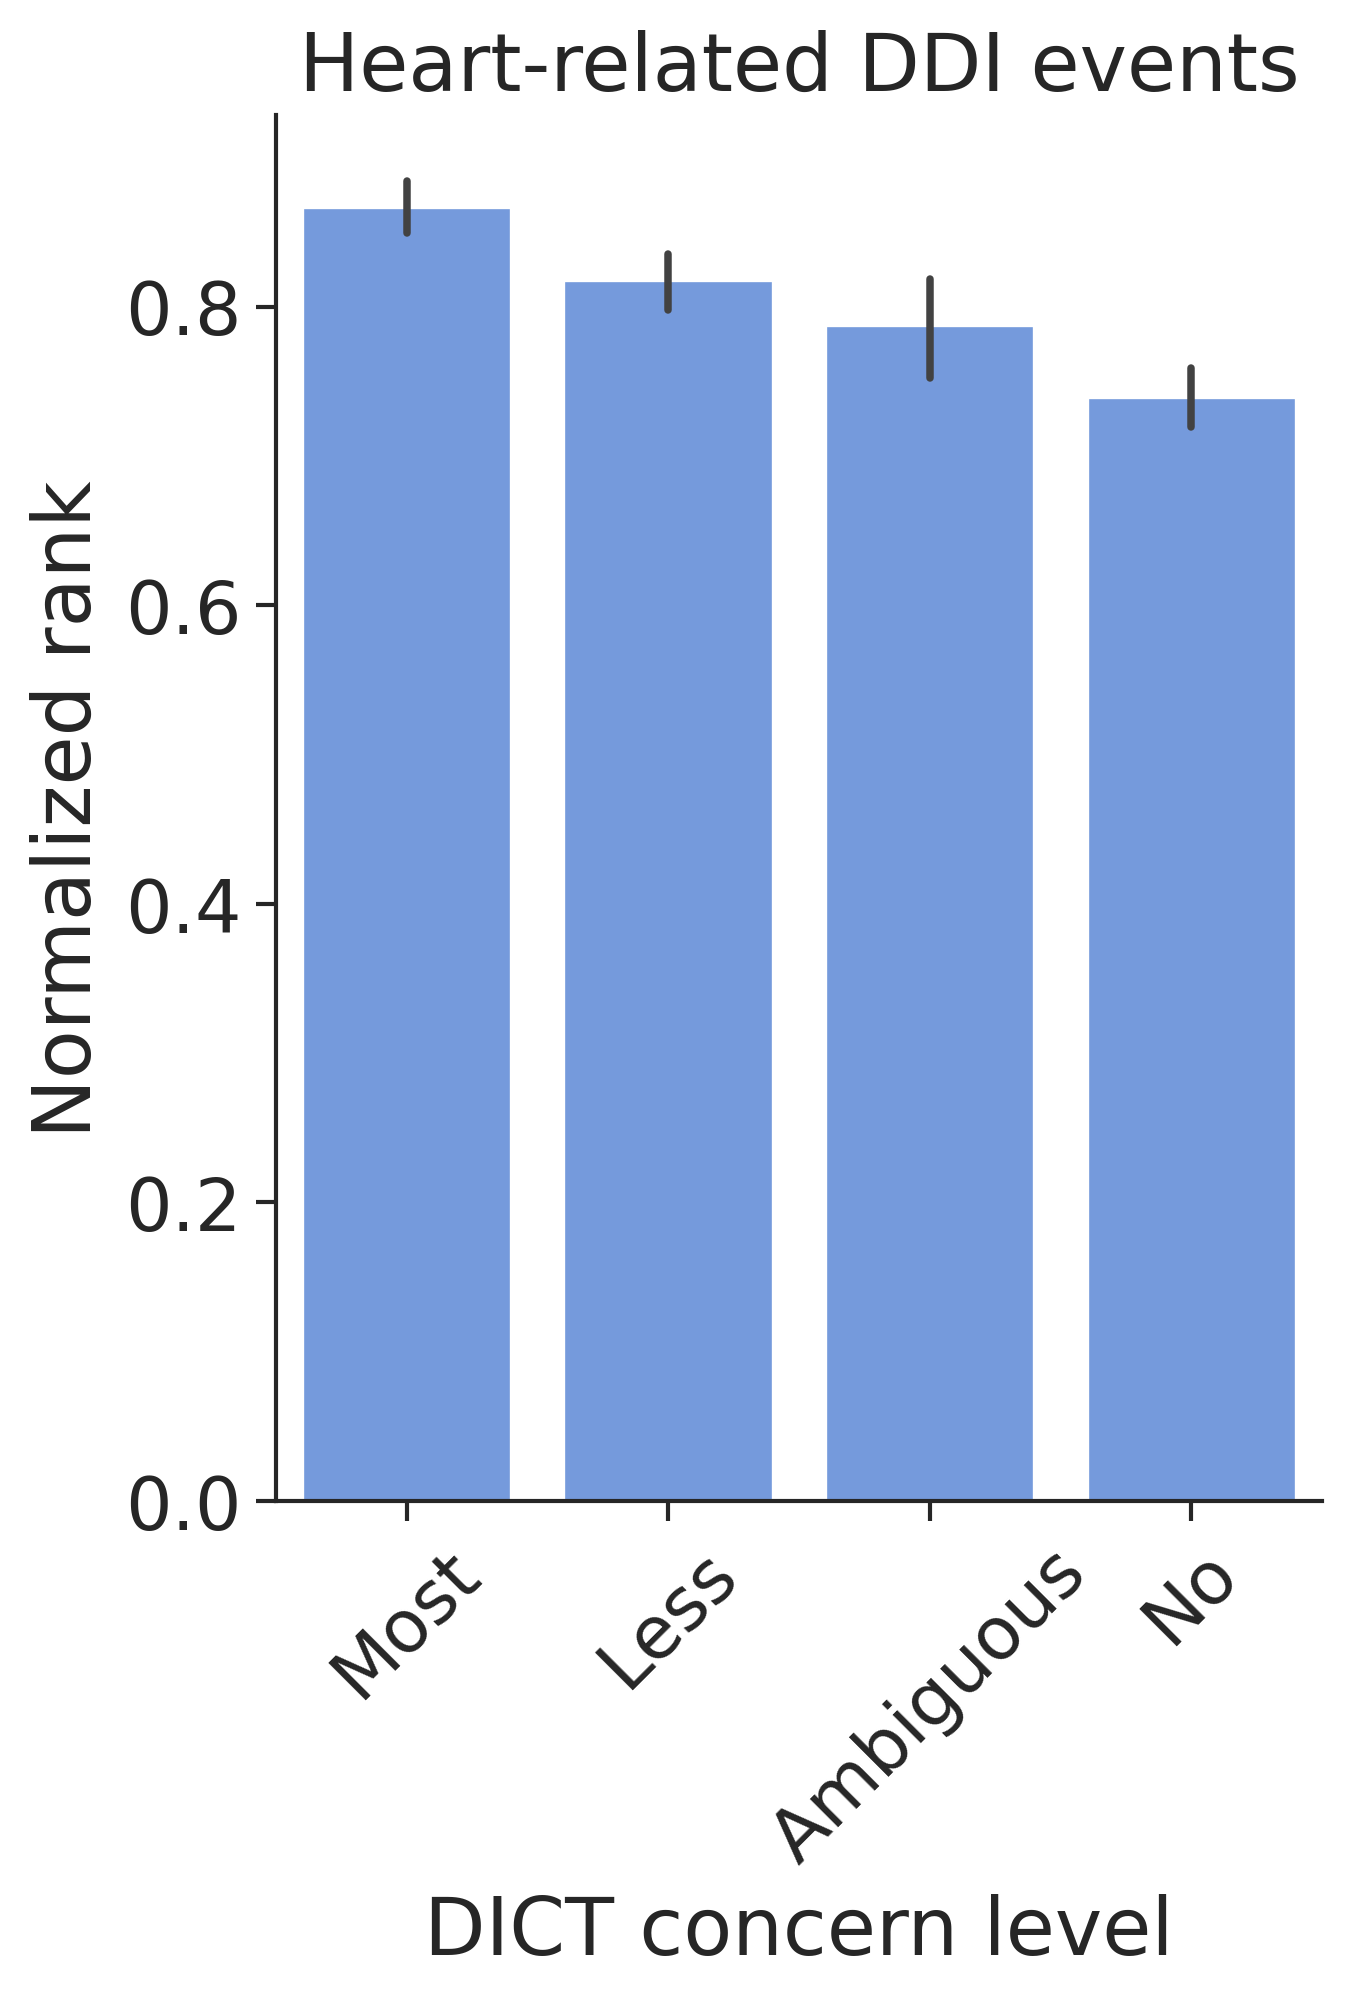

MannwhitneyuResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=nan, pvalue=nan)
MannwhitneyuResult(statistic=nan, pvalue=nan)


In [ ]:
plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=dict_data_agg, x="DICT_concern", y="heart_ddi_classes_highest_5_mean_norm_rank", 
            order=["Most", "Less", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DICT concern level")
plt.ylabel("Normalized rank")  # Highest 5 mean of normalized ranks\nof heart-related DDI classes
plt.title("Heart-related DDI events")
plt.xticks(rotation=45)
# plt.ylim(0.601)
# plt.savefig("../figs/fig2_self_combo_dict_heart_related.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Most"]["heart_ddi_classes_highest_5_mean"].values, 
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Less"]["heart_ddi_classes_highest_5_mean"].values, 
))
print(mannwhitneyu(
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Less"]["heart_ddi_classes_highest_5_mean"].values, 
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Ambiguous"]["heart_ddi_classes_highest_5_mean"].values, 
))
print(mannwhitneyu(
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Ambiguous"]["heart_ddi_classes_highest_5_mean"].values, 
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "No"]["heart_ddi_classes_highest_5_mean"].values, 
))
print(mannwhitneyu(
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "Less"]["heart_ddi_classes_highest_5_mean"].values, 
    dict_data_agg[dict_data_agg["DICT _ Concern"] == "No"]["heart_ddi_classes_highest_5_mean"].values, 
))

## Drug-Induced QT Prolongation Atlas

[DIQTA](https://www.adratlas.com/DIQTA/) dataset

[original paper](https://www.sciencedirect.com/science/article/pii/S1359644621004475)

In [ ]:
diqt_data = pd.read_excel(BASE_DIR + "raw_data/DIQTA/DIQT-Drug Information.xlsx", sheet_name=0)
diqt_data["Classification"] = diqt_data["Classification"].fillna(diqt_data["Unnamed: 32"])
diqt_data = diqt_data.dropna(subset=["Drugbank_ID"])

non_diqt_data = pd.read_excel(BASE_DIR + "raw_data/DIQTA/NON-DIQT-Drug Information.xlsx", sheet_name=0)
print(non_diqt_data.shape[0])
non_diqt_data = (
    non_diqt_data.
    dropna(subset=["DrugbankID"]).
    query("DrugbankID in @drug_metadata.node_id.dropna().values")[["DrugbankID"]].
    rename(columns={"DrugbankID":'Drugbank_ID'})
)
print(non_diqt_data.shape[0])

In [10]:
(diqt_data[["Classification", "Severity Score"]].dropna()["Classification"] + "_" + diqt_data[["Classification", "Severity Score"]].dropna()["Severity Score"].astype(str)).value_counts()

Ambiguous_1.0                262
Most-DIQT concern_4.0         83
Moderate-DIQT concern_3.0     36
Moderate-DIQT concern_2.0     20
Most-DIQT concern_5.0         12
Name: count, dtype: int64

In [11]:
all_diqt_data = pd.concat([
    diqt_data[["Drugbank_ID", "Classification"]],
    non_diqt_data
])
print(all_diqt_data.shape[0])
all_diqt_data["Classification"] = all_diqt_data["Classification"].fillna("No-DIQT concern")
all_diqt_data = all_diqt_data.merge(
    drug_metadata[["node_id"]].reset_index().dropna(), how="inner", left_on="Drugbank_ID", right_on="node_id"
).drop(columns=["node_id"]).rename(columns={"index":"drug_ind"}).reset_index(drop=True)
print(all_diqt_data.shape[0])

527
505


In [12]:
all_diqt_data["Classification"].value_counts()

Classification
Ambiguous                241
Most-DIQT concern        109
No-DIQT concern          100
Moderate-DIQT concern     55
Name: count, dtype: int64

In [13]:
qt_ddi_class_indices = [i for i, ddi_class_name in enumerate(ddi_classes) if "QT" in ddi_class_name]
qt_ddi_class_indices_filtered = list(set(qt_ddi_class_indices) - set(to_delete))
print(qt_ddi_class_indices_filtered)
print([ddi_classes[i] for i in qt_ddi_class_indices_filtered])

[3, 4, 5, 6]
['QTc prolongation, decrease', 'QTc prolongation, hypotension, increase', 'QTc prolongation, increase', 'QTc prolongation, torsade de pointes, cardiotoxicity, increase']


In [14]:
# get normalized ranks of each drug self-combo for each filtered liver class
class_normalized_rank_drugbank_self_combos = {}
for ddi_class_ind in qt_ddi_class_indices_filtered:
    class_normalized_rank_drugbank_self_combos[ddi_class_ind] = normalized_ranks_drugbank_self_combos_gmean_aggregated[ddi_class_ind, :]
    all_diqt_data[f"ddi_class_{ddi_class_ind}_norm_rank"] = class_normalized_rank_drugbank_self_combos[ddi_class_ind][all_diqt_data["drug_ind"].values]

all_diqt_data["DIQT_concern"] = all_diqt_data["Classification"].replace({
    "Most-DIQT concern":"Most", "Moderate-DIQT concern":"Moderate", "Ambiguous":"Ambiguous", "No-DIQT concern":"No"
})

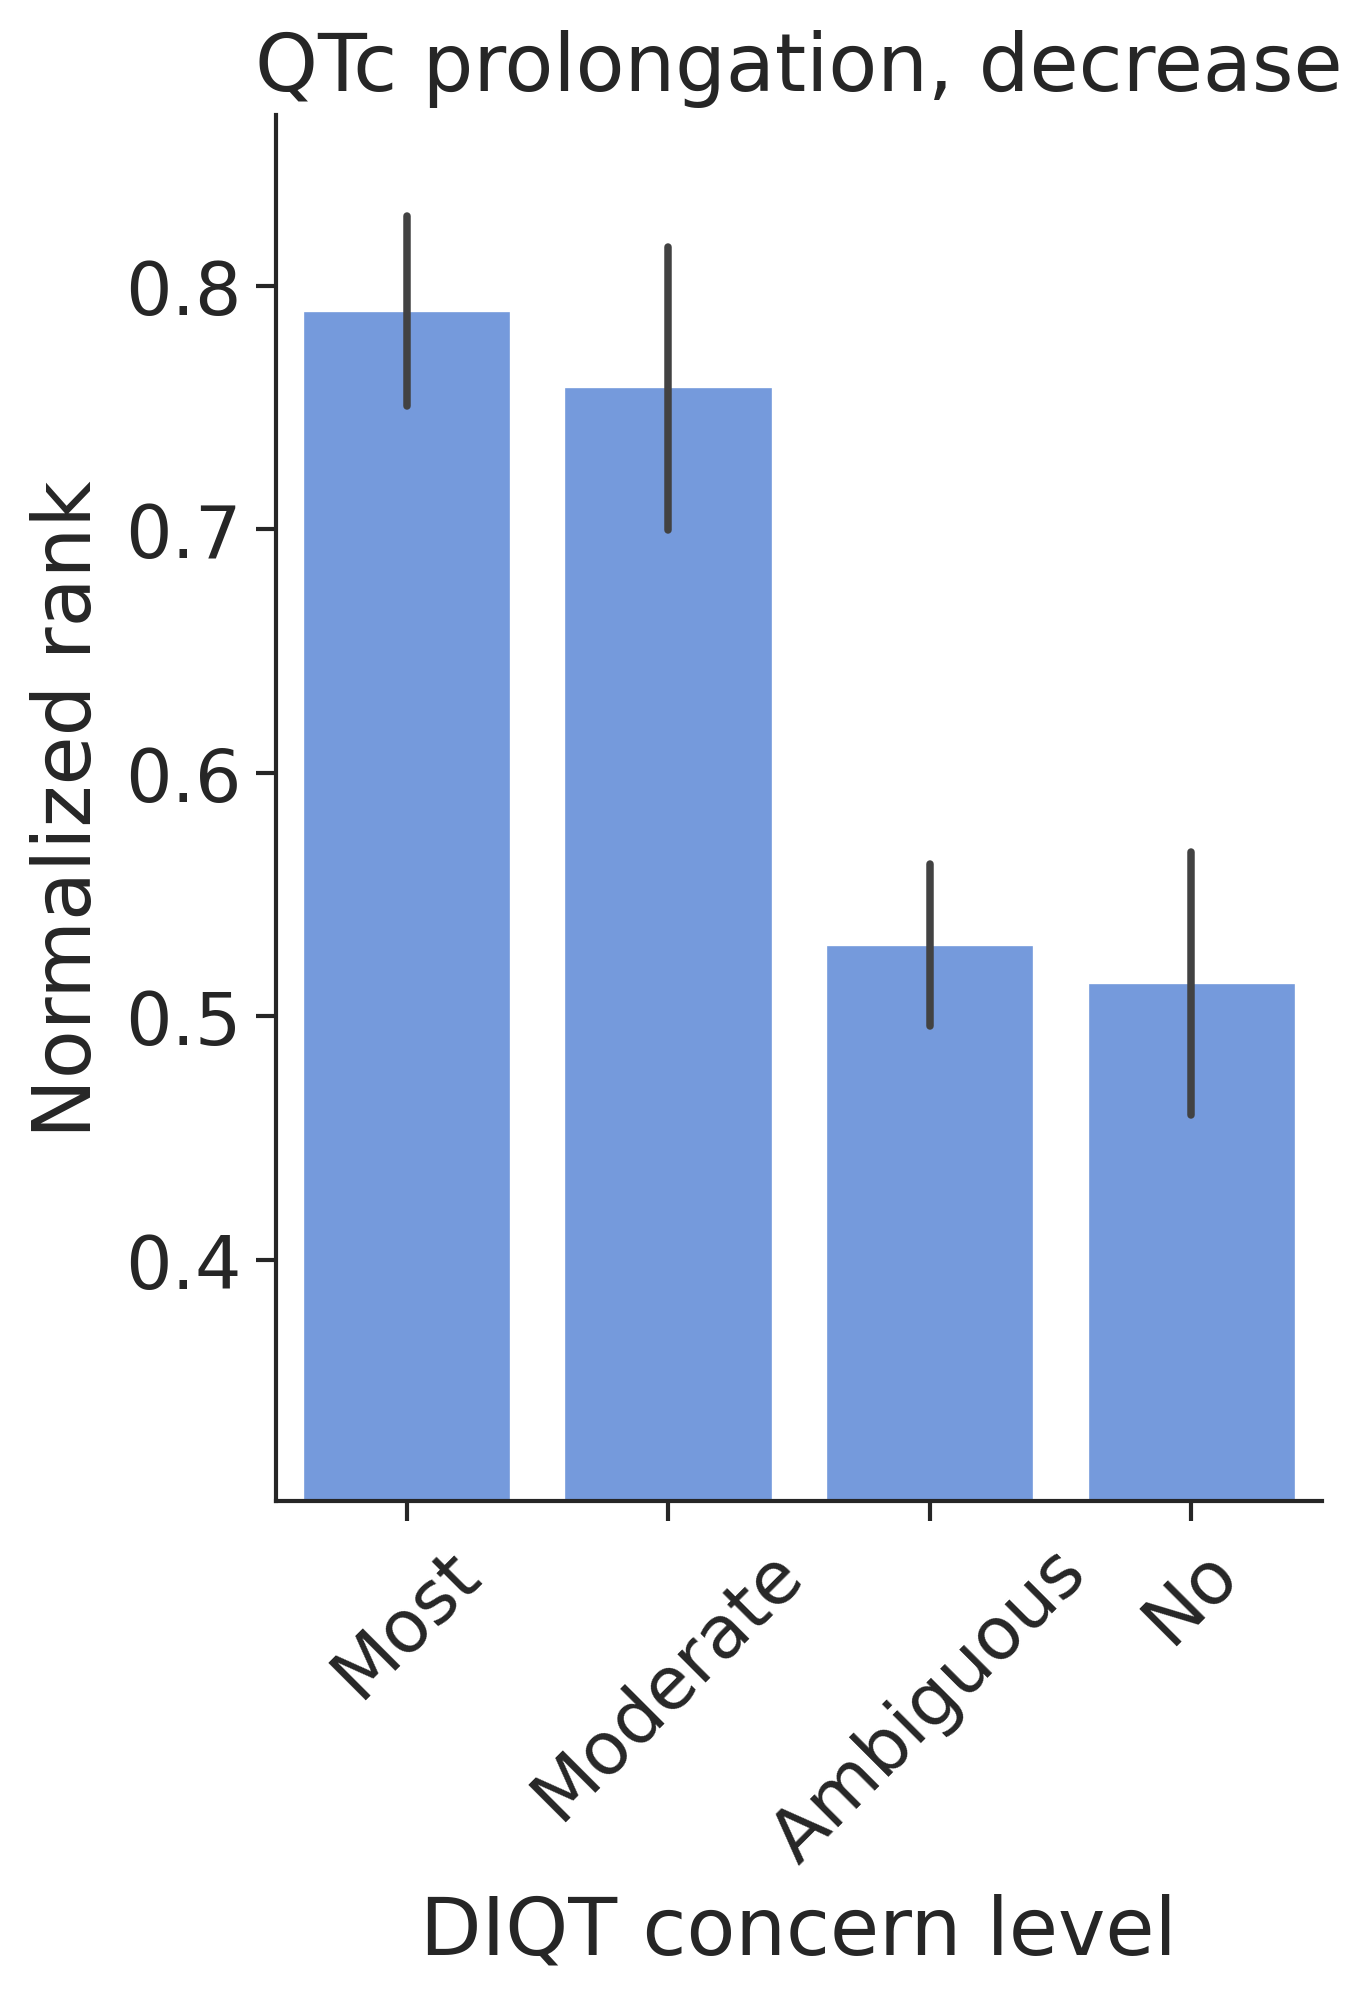

MannwhitneyuResult(statistic=3338.5, pvalue=0.23563528273217327)
MannwhitneyuResult(statistic=9848.5, pvalue=1.8798128509374663e-08)
MannwhitneyuResult(statistic=12392.0, pvalue=0.6802959111039589)
MannwhitneyuResult(statistic=4177.0, pvalue=9.564595872820035e-08)


In [ ]:
ddi_class_ind = 3
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=all_diqt_data, x="DIQT_concern", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Moderate", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DIQT concern level")
plt.ylabel("Normalized rank")  # Highest 5 mean of normalized ranks\nof heart-related DDI classes
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_diqt_qtc_prolongation_decrease.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Most-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

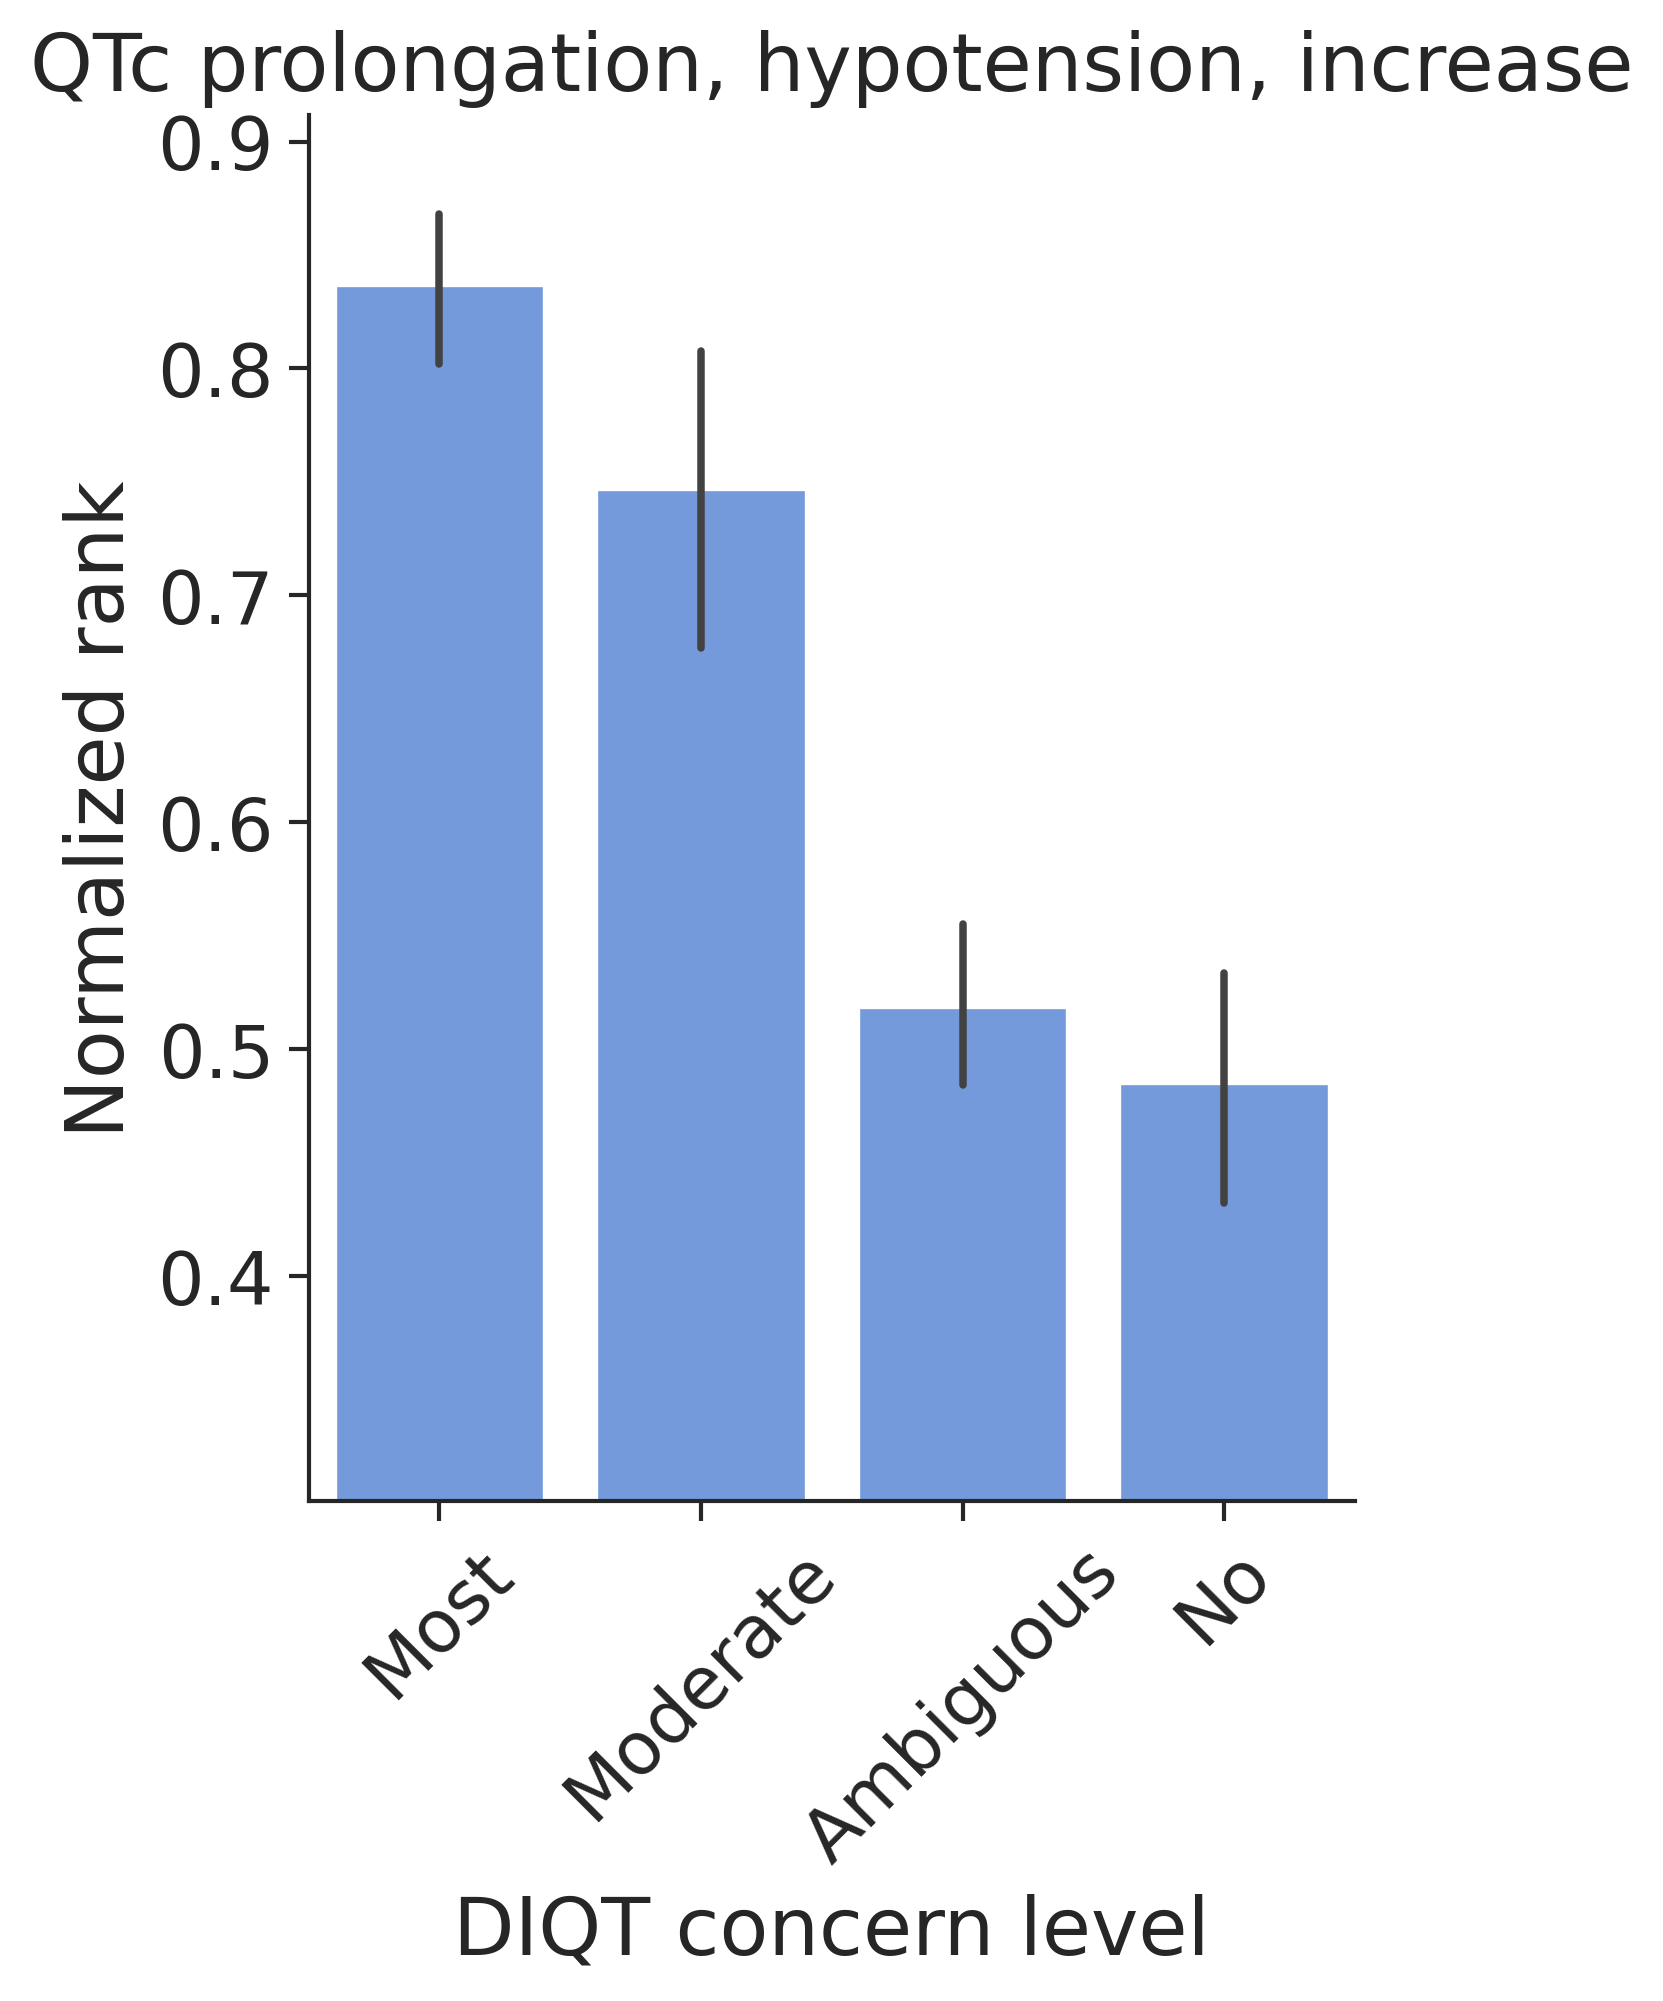

MannwhitneyuResult(statistic=3807.5, pvalue=0.00480982504786815)
MannwhitneyuResult(statistic=9911.5, pvalue=9.884100140728345e-09)
MannwhitneyuResult(statistic=12901.0, pvalue=0.3047846388559431)
MannwhitneyuResult(statistic=4201.0, pvalue=5.809668063826337e-08)


In [ ]:
ddi_class_ind = 4
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=all_diqt_data, x="DIQT_concern", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Moderate", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DIQT concern level")
plt.ylabel("Normalized rank")  # Highest 5 mean of normalized ranks\nof heart-related DDI classes
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_diqt_qtc_prolongation_hypotension_increase.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Most-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

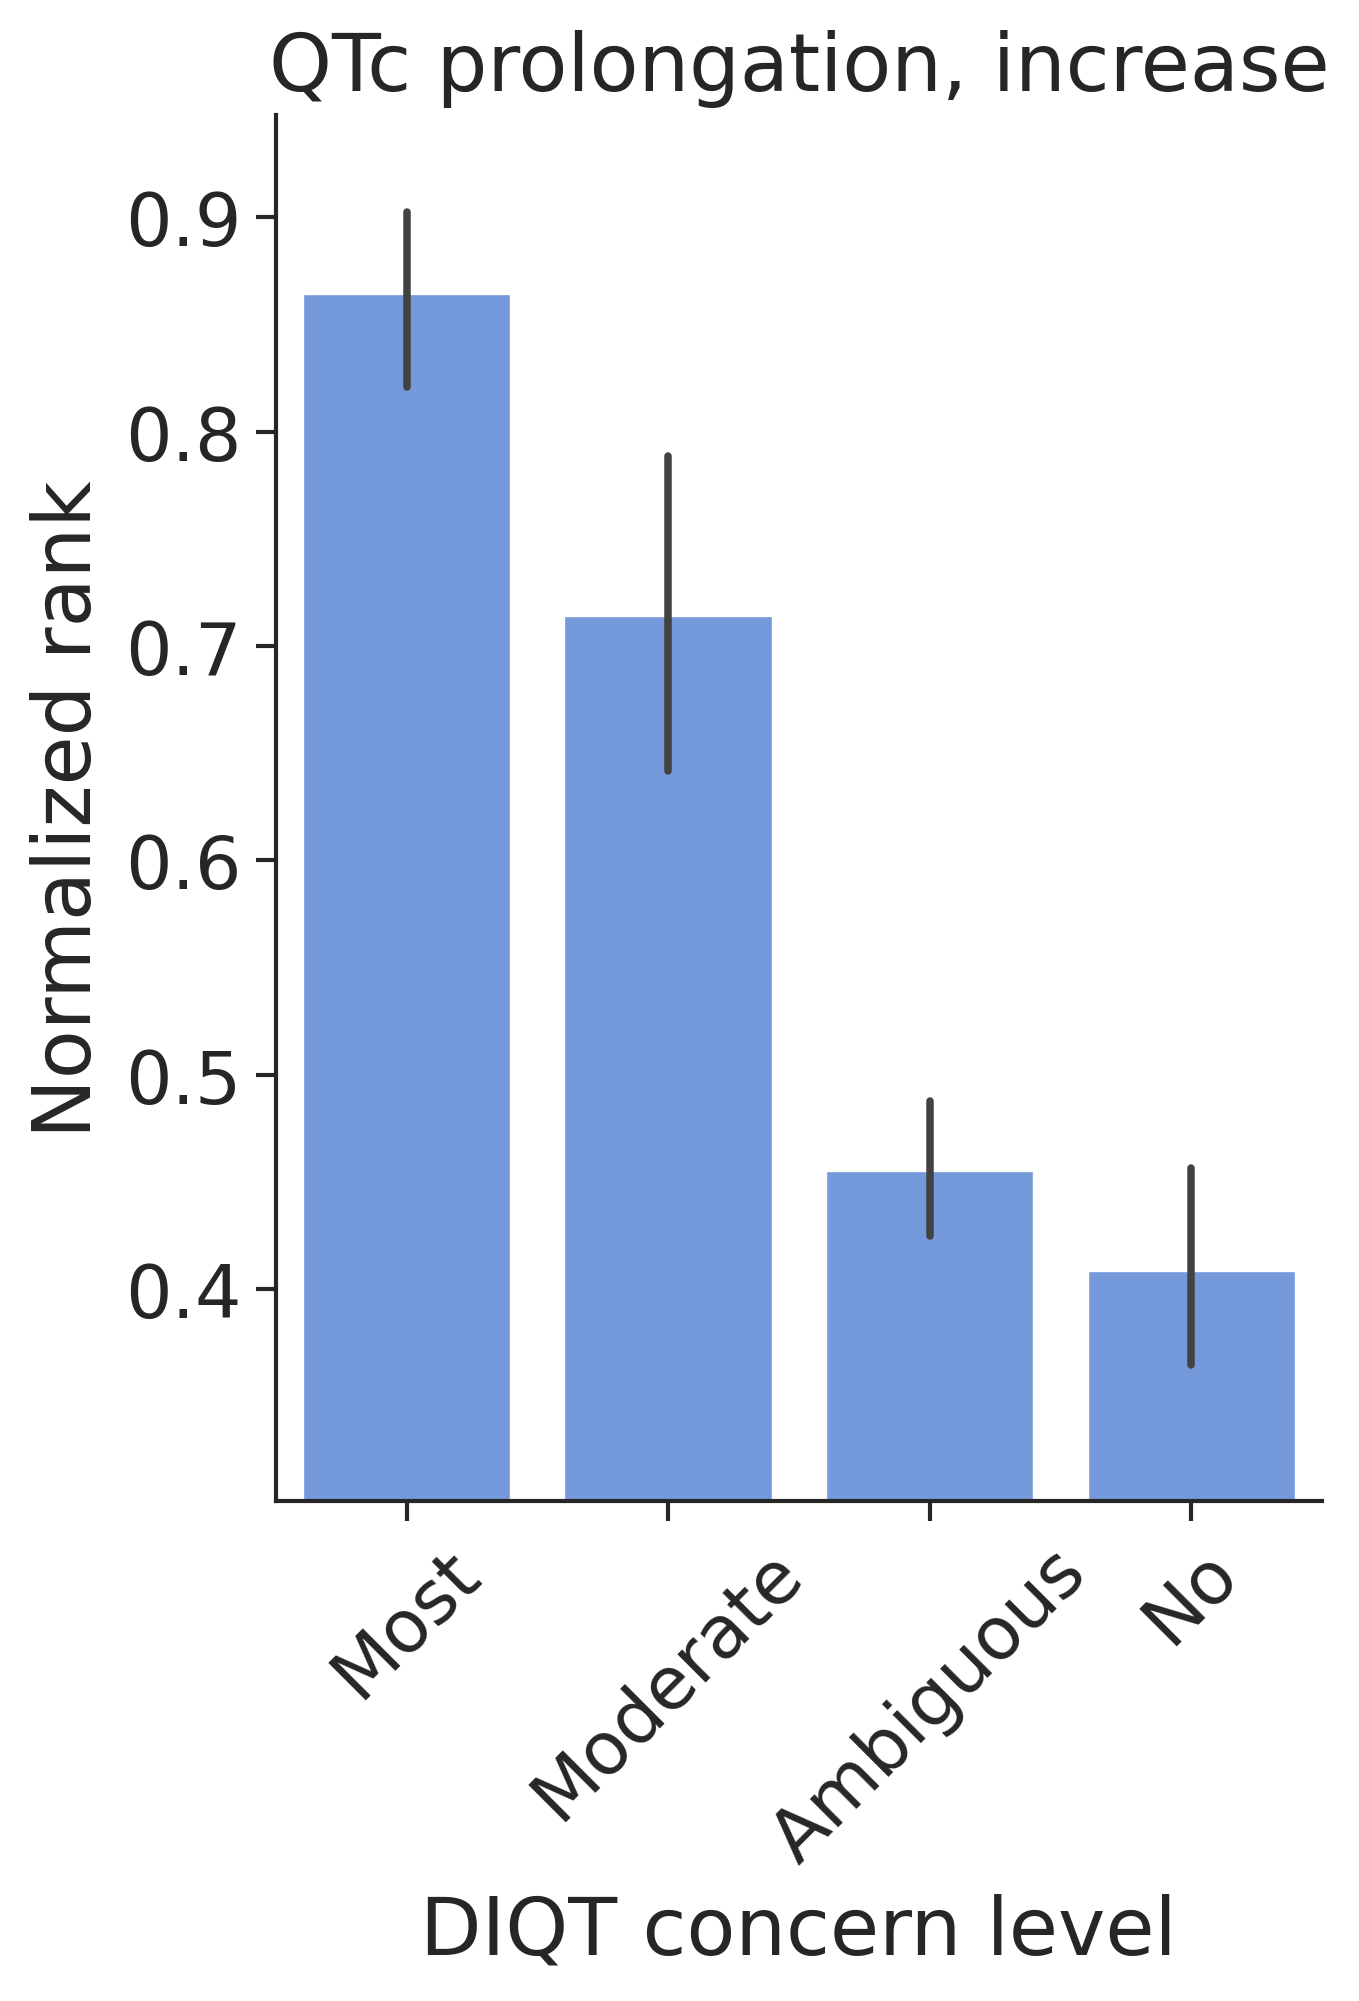

MannwhitneyuResult(statistic=4265.5, pvalue=1.0113920626692025e-05)
MannwhitneyuResult(statistic=9828.5, pvalue=2.2997089403018484e-08)
MannwhitneyuResult(statistic=13458.0, pvalue=0.08944888601933934)
MannwhitneyuResult(statistic=4307.0, pvalue=5.850358486669817e-09)


In [ ]:
ddi_class_ind = 5
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=all_diqt_data, x="DIQT_concern", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Moderate", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DIQT concern level")
plt.ylabel("Normalized rank")  # Highest 5 mean of normalized ranks\nof heart-related DDI classes
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_diqt_qtc_prolongation_increase.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Most-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))

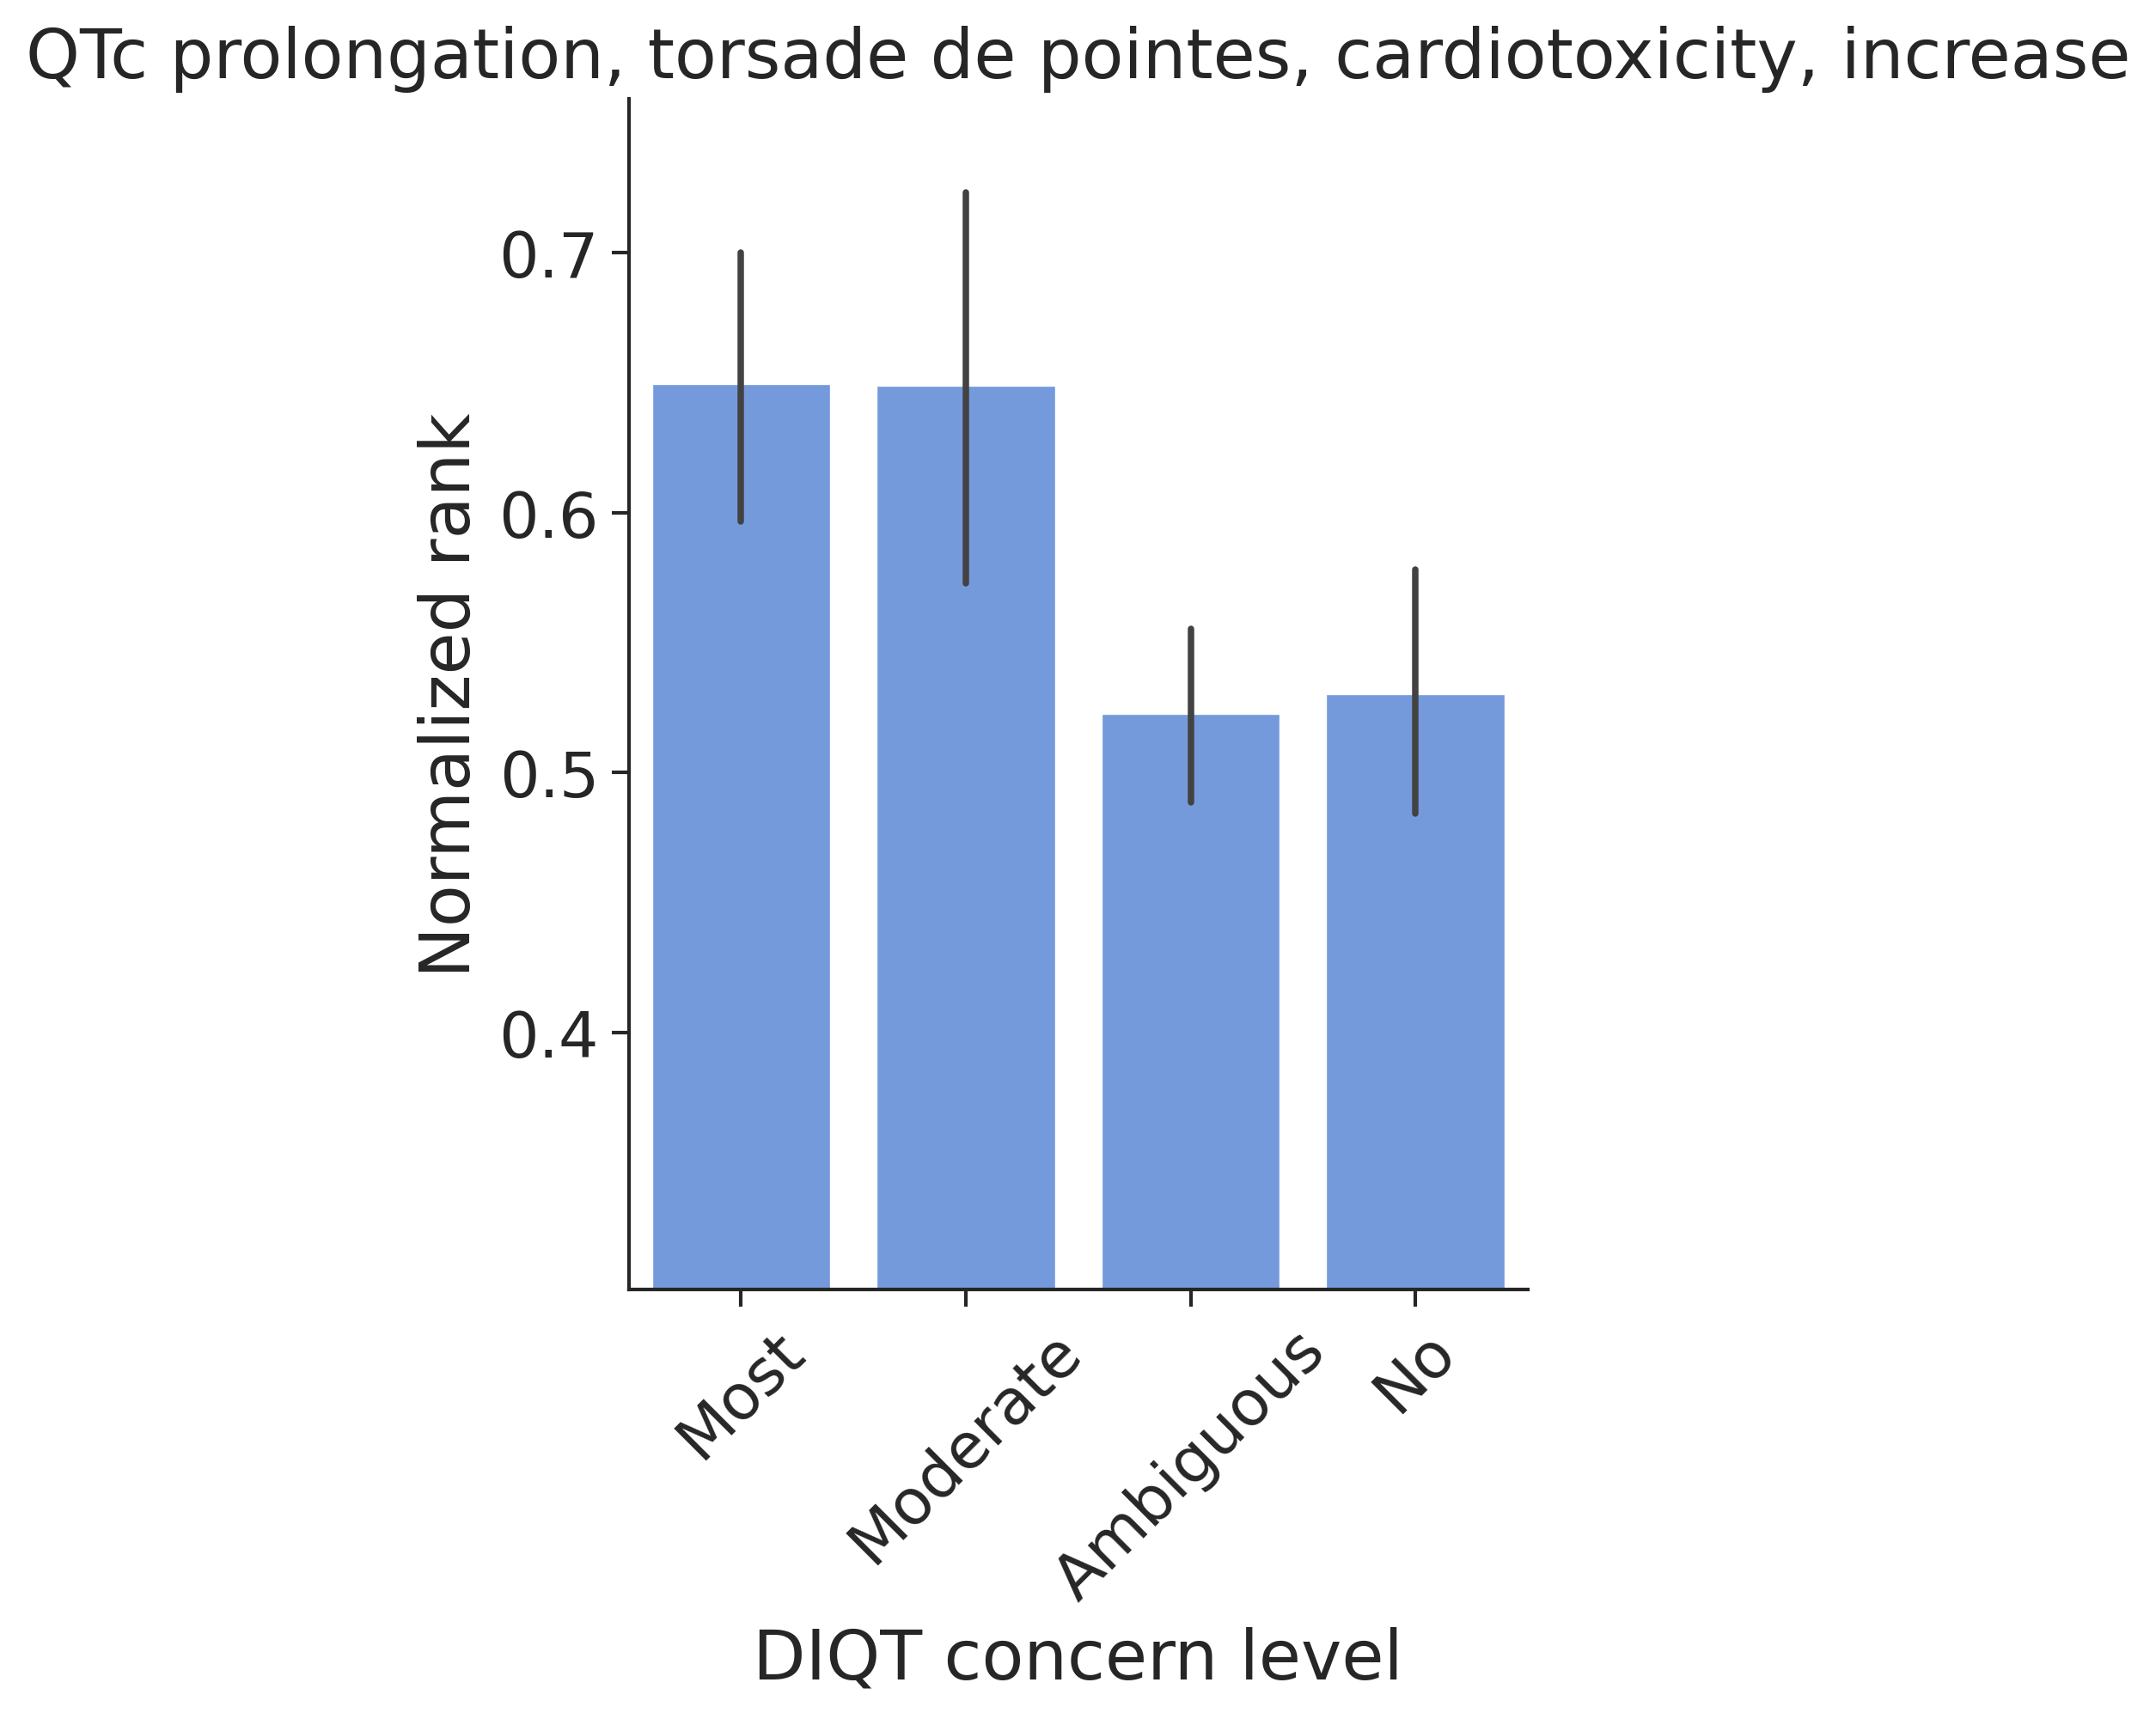

MannwhitneyuResult(statistic=3067.5, pvalue=0.8087261962339034)
MannwhitneyuResult(statistic=8358.5, pvalue=0.002516896219604602)
MannwhitneyuResult(statistic=11862.0, pvalue=0.8210143719582677)
MannwhitneyuResult(statistic=3464.0, pvalue=0.0076227368337679294)


In [ ]:
ddi_class_ind = 6
ddi_class = ddi_classes[ddi_class_ind]

plt.figure(figsize=(4.5, 6), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

sns.barplot(data=all_diqt_data, x="DIQT_concern", y=f"ddi_class_{ddi_class_ind}_norm_rank", 
            order=["Most", "Moderate", "Ambiguous", "No"], color="cornflowerblue")
sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.xlabel("DIQT concern level")
plt.ylabel("Normalized rank")  # Highest 5 mean of normalized ranks\nof heart-related DDI classes
plt.title(f"{ddi_class}")
plt.xticks(rotation=45)
plt.ylim(0.301)
# plt.savefig("../figs/fig2_self_combo_diqt_qtc_prolongation_torsade_de_pointes_cardiotoxicity_increase.svg", format="svg", dpi=300)
plt.show()

print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Most-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Ambiguous'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))
print(mannwhitneyu(
    all_diqt_data.query("Classification == 'Moderate-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
    all_diqt_data.query("Classification == 'No-DIQT concern'")[f"ddi_class_{ddi_class_ind}_norm_rank"].values, 
))